## Preliminares

In [1]:
import tensorflow as tf
import logging
# Ajusta el nivel de logs a ERROR para ocultar warnings y otros mensajes menos críticos
tf.get_logger().setLevel(logging.ERROR)

# Verificar dispositivos disponibles
if tf.test.gpu_device_name():
    print('GPU encontrada:', tf.test.gpu_device_name())
else:
    print("No se encontró GPU. Se utilizará la CPU.")

# Listar todas las GPU disponibles
gpus = tf.config.experimental.list_physical_devices('GPU')

# Configurar el crecimiento de memoria para cada GPU
if gpus:
    for gpu in gpus:
        print("Activada la asignacion de memoria gradual")
        tf.config.experimental.set_memory_growth(gpu, True)

2024-12-19 13:15:30.069156: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-19 13:15:30.077253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734610530.086657   87466 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734610530.089428   87466 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 13:15:30.099422: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

GPU encontrada: /device:GPU:0
Activada la asignacion de memoria gradual


I0000 00:00:1734610531.169645   87466 gpu_device.cc:2022] Created device /device:GPU:0 with 6774 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1
I0000 00:00:1734610531.170229   87466 gpu_device.cc:2022] Created device /device:GPU:0 with 6774 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1


## hola

In [1]:
BATCH = 25

In [2]:
import numpy as np
import math
import cv2
from PIL import Image, ImageEnhance ,ImageFilter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import pandas as pd
#os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import sqlite3
import shutil

 # Comprobar si el archivo existe
if not os.path.exists('../datos/grabacion/base_datos_cod_augmented.db'):
    # Copiar el archivo
    shutil.copy('../datos/grabacion/base_datos_cod.db', '../datos/grabacion/base_datos_cod_augmented.db')
    print("Archivo copiado exitosamente..")
else:
    print("Archivo ya existe..")

# Conectar a la base de datos (crea el archivo si no existe)
conexion = sqlite3.connect("../datos/grabacion/base_datos_cod_augmented.db")

# Crear un cursor para interactuar con la base de datos
cursor = conexion.cursor()

Archivo ya existe..


In [4]:
cursor.execute("SELECT MAX(id) FROM videos_mapa")
ID = cursor.fetchone()[0]

if ID == None:
    ID = 0

ID

4767

In [5]:
CANTIDAD_VIDEOS = 5

cursor.execute("SELECT id as id_video, COUNT(*) AS cantidad FROM videos_mapa GROUP BY id HAVING COUNT(*) > "+str(CANTIDAD_VIDEOS)+"")
resultados = cursor.fetchall()

# Obtener los nombres de las columnas
columnas = [descripcion[0] for descripcion in cursor.description]

# Crear el DataFrame
df_ids = pd.DataFrame(resultados, columns=columnas)

# Utilizando .to_numpy()
ARRAY_ID = df_ids['id_video'].to_numpy()

In [6]:
ARRAY_ID

array([   0,    1,    2, ..., 4765, 4766, 4767])

In [7]:
# Dividir en entrenamiento y prueba (10% para prueba)
X_train_Mapa, X_test_Mapa = train_test_split(ARRAY_ID, test_size=0.1, random_state=42)
# Dividir entrenamiento en entrenamiento y validación (30% de 90% para validación)
#X_train_Mapa, X_valid_Mapa = train_test_split(X_train_Mapa, test_size=0.3, random_state=42)

In [8]:
print("train ->"+str(len(X_train_Mapa)))
#print("valid ->"+str(len(X_valid_Mapa)))
print("test ->"+str(len(X_test_Mapa)))

train ->3471
test ->386


In [9]:
def crear_dataframe(lista_ids):
    # Crear un DataFrame vacío para almacenar los resultados
    df_mapa = pd.DataFrame()
    df_pov = pd.DataFrame()

    for id in lista_ids:
        query = f"SELECT * FROM videos_mapa WHERE id == {id}"
        query_pov = f"SELECT * FROM videos_pov WHERE id == {id}"

        # Leer el resultado de la consulta y añadirlo al DataFrame
        df_temporal = pd.read_sql_query(query, conexion)
        df_temporal_pov = pd.read_sql_query(query_pov, conexion)

        # Concatenar al DataFrame principal
        df_mapa = pd.concat([df_mapa, df_temporal], ignore_index=True)
        df_pov = pd.concat([df_pov, df_temporal_pov], ignore_index=True)
    
    return df_mapa , df_pov

In [10]:
def crear_dataframe(lista_ids):
    # Crear un DataFrame vacío para almacenar los resultados
    df_mapa = pd.DataFrame()
    df_pov = pd.DataFrame()

    for id in lista_ids:
        query = f"SELECT * FROM videos_mapa WHERE id == {id}"
        query_pov = f"SELECT * FROM videos_pov WHERE id == {id}"

        # Leer el resultado de la consulta y añadirlo al DataFrame
        df_temporal = pd.read_sql_query(query, conexion)
        df_temporal_pov = pd.read_sql_query(query_pov, conexion)

        # Concatenar al DataFrame principal
        df_mapa = pd.concat([df_mapa, df_temporal], ignore_index=True)
        df_pov = pd.concat([df_pov, df_temporal_pov], ignore_index=True)
    
    return df_mapa , df_pov

In [11]:
import ast

def preprocesado_df(df):
    # Convertir la columna de tipo object a listas de enteros
    df['etiqueta'] = df['etiqueta'].apply(ast.literal_eval)
    # Eliminamos las filas donde 'mouse_final' sea igual a [0, 4]
    filtro = df['etiqueta'].apply(lambda x: x[1] == 4)
    df = df[~filtro]
    # Crear un filtro booleano para las filas que cumplen la condición
    condicion = df['etiqueta'].apply(lambda x: x[1] == 2)
    # Juntamos las pulsaciones y tecla en una columna
    #x_positions_2 = df['etiqueta'].apply(lambda x: str(x[0])+str(x[1]))
    x_positions_2 = df['etiqueta'].apply(lambda x: str(x[1]))
    df['etiqueta'] = x_positions_2
    # Modificar solo las filas que cumplen con la condición
    #df.loc[condicion, 'etiqueta'] = df.loc[condicion, 'etiqueta'].apply(lambda x: "12")
    return df

In [12]:
df_train_mapa , df_train_pov = crear_dataframe(X_train_Mapa)
#df_valid_mapa , df_valid_pov = crear_dataframe(X_valid_Mapa)
df_test_mapa , df_test_pov = crear_dataframe(X_test_Mapa)

In [13]:
df_train_mapa = preprocesado_df(df_train_mapa)
#df_valid_mapa = preprocesado_df(df_valid_mapa)
df_test_mapa = preprocesado_df(df_test_mapa)

/tmp/ipykernel_9114/1242670720.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['etiqueta'] = x_positions_2


In [14]:
conexion.close()

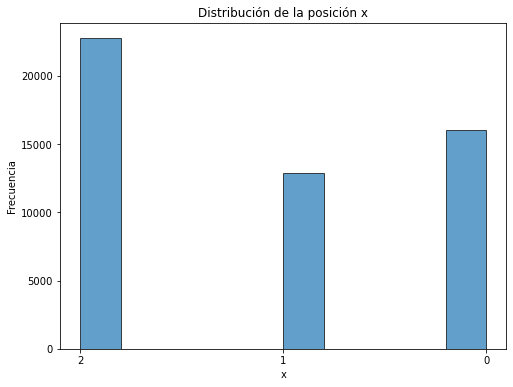

In [15]:
# Extraer la primera posición sin modificar el DataFrame
x_positions = df_train_mapa['etiqueta'].apply(lambda x: x[0])

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(8, 6))

# Crear el histograma
ax.hist(x_positions, bins=10, edgecolor='black', alpha=0.7)

# Agregar el título y las etiquetas de los ejes
ax.set_title('Distribución de la posición x')
ax.set_xlabel('x')
ax.set_ylabel('Frecuencia')

# Mostrar la figura
plt.show()

In [16]:
from sklearn.utils import class_weight

def aplicar_one_hot_balanceo(df,columa):
    # Crear un DataFrame con las columnas de one-hot encoding
    one_hot_df = pd.get_dummies(df[columa], prefix='label')

    # Unir el DataFrame original con el DataFrame de one-hot encoding
    df = pd.concat([df, one_hot_df], axis=1)

    # Balanceamos los pesos para el entrenamiento
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(df[columa]),
        y=df[columa]
    )

    # Crear un diccionario de pesos para las clases
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    #Eliminamos la columna original
    df = df.drop(columa, axis=1)
    return df , class_weight_dict

In [17]:
df_train_mapa , pesos_train = aplicar_one_hot_balanceo(df_train_mapa,"etiqueta")
#df_valid_mapa , pesos_valid = aplicar_one_hot_balanceo(df_valid_mapa,"etiqueta")
df_test_mapa , pesos_test= aplicar_one_hot_balanceo(df_test_mapa,"etiqueta")

In [18]:
pesos_train

{0: 1.0723581792141479, 1: 1.340468591889157, 2: 0.7567341916772861}

In [19]:
ETIQUETAS = np.array(df_train_mapa.filter(like='label').columns.tolist())

In [20]:
from keras.utils import Sequence

class ImageDataGenerator(Sequence):
    def __init__(self, df , sequence_length ,image_height , image_width , batch_size, filtro, **kwargs):
        self.df = df
        self.image_sequence_length = sequence_length
        self.image_height = image_height
        self.image_width = image_width
        self.batch_size = batch_size
        self.POV = filtro
        super().__init__(**kwargs)  # Llamada al constructor de la clase base

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def cargar_todo(self,fin_df):
        batch_df = self.df.iloc[0:fin_df]     #Obtenemos un lote del df

        X_batch = np.zeros((len(batch_df), self.image_sequence_length ,self.image_height, self.image_width, 3))  # Inicializar matriz para las imágenes
        #y_batch = batch_df[['izquieda', 'derecha', 'delante']].values
        y_batch = np.array(batch_df['mouse_final'].tolist())

        for i, (_, row) in enumerate(batch_df.iterrows()):
            frames = []
            for j in range(self.image_sequence_length):
                imagen = Image.open("../" + row.iloc[j])    # Obtener la ruta de la imagen
                imagen = Image.fromarray(np.array(imagen)).filter(ImageFilter.SHARPEN)  #Aplicamos Filtro SHARPEN
                imagen = np.array(imagen) / 255.0           # Normalizar la imagen

                frames.append(imagen)                  #Juntamos frames en lista
            video = np.stack(frames, axis=0)           # Convertir lista de frames en un video np
            X_batch[i] = video

        return X_batch, y_batch

    def __getitem__(self, index):
        inicio_lote = index * self.batch_size
        final_lote = (index + 1) * self.batch_size

        batch_df = self.df.iloc[inicio_lote:final_lote]     #Obtenemos un lote del df

        X_batch = np.zeros((len(batch_df), self.image_sequence_length ,self.image_height, self.image_width, 3))  # Inicializar matriz para las imágenes
        # Obtener y_batch después del one-hot encoding
        #y_batch = batch_df[['izquieda', 'derecha','delante']].values
        #y_batch = np.array(batch_df['mouse_final'].tolist())

        # Filtrar las columnas que comienzan con 'label'
        y_batch = batch_df.filter(like='label').values

        for i, (_, row) in enumerate(batch_df.iterrows()):
            frames = []
            for j in range(self.image_sequence_length):
                imagen = Image.open("../" + row.iloc[j+2])    # Obtener la ruta de la imagen
                ancho, alto = imagen.size

                if self.POV == True :
                    imagen = imagen.rotate(2.5, expand=True)
                    # Recorta la imagen (izquierda, superior, derecha, inferior)
                    imagen = imagen.crop((5, 12, ancho - 35, alto-25))
                    imagen = ImageEnhance.Sharpness(imagen)
                    imagen = imagen.enhance(7)  # Aumento de contraste

                imagen = np.array(imagen) / 255.0           # Normalizar la imagen

                frames.append(imagen)                  #Juntamos frames en lista
            video = np.stack(frames, axis=0)           # Convertir lista de frames en un video np
            X_batch[i] = video

        return X_batch, y_batch

def comprobar_contenido(X_train , Y_train , num_video):

    fig, axs = plt.subplots(1, 5, figsize=(5 * 2, 1 * 2))

    for i in range(5):
        axs[i].imshow(X_train[num_video][i])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()
    print(Y_train[num_video])
    return Y_train[num_video]

2024-12-24 10:53:27.829030: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-24 10:53:28.682643: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735034008.852547    9114 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735034008.903335    9114 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-24 10:53:29.839397: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [21]:
class ImageDataGeneratorVAR(ImageDataGenerator):
    def __init__(self, df , sequence_length ,image_height , image_width , batch_size, filtro,autoencoder,encoder = None,**kwargs):
        self.autoencoder = autoencoder
        self.encoder_entrenado = encoder
        super().__init__(df, sequence_length, image_height, image_width, batch_size, filtro, **kwargs)

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def cargar_todo(self,fin_df):
        batch_df = self.df.iloc[0:fin_df]     #Obtenemos un lote del df

        X_batch = np.zeros((len(batch_df), self.image_sequence_length ,self.image_height, self.image_width, 3))  # Inicializar matriz para las imágenes
        #y_batch = batch_df[['izquieda', 'derecha', 'delante']].values
        y_batch = np.array(batch_df['mouse_final'].tolist())

        for i, (_, row) in enumerate(batch_df.iterrows()):
            frames = []
            for j in range(self.image_sequence_length):
                imagen = Image.open("../" + row.iloc[j])    # Obtener la ruta de la imagen
                imagen = Image.fromarray(np.array(imagen)).filter(ImageFilter.SHARPEN)  #Aplicamos Filtro SHARPEN
                imagen = np.array(imagen) / 255.0           # Normalizar la imagen

                frames.append(imagen)                  #Juntamos frames en lista
            video = np.stack(frames, axis=0)           # Convertir lista de frames en un video np
            X_batch[i] = video

        return X_batch, y_batch

    def __getitem__(self, index):
        inicio_lote = index * self.batch_size
        final_lote = (index + 1) * self.batch_size

        batch_df = self.df.iloc[inicio_lote:final_lote]     #Obtenemos un lote del df

        X_batch = np.zeros((len(batch_df), self.image_sequence_length ,self.image_height, self.image_width, 3))  # Inicializar matriz para las imágenes

        # Filtrar las columnas que comienzan con 'label'
        y_batch = batch_df.filter(like='label').values

        for i, (_, row) in enumerate(batch_df.iterrows()):
            frames = []
            for j in range(self.image_sequence_length):
                imagen = Image.open("../" + row.iloc[j+2])    # Obtener la ruta de la imagen
                ancho, alto = imagen.size

                if self.POV == True :
                    imagen = imagen.rotate(2.5, expand=True)
                    # Recorta la imagen (izquierda, superior, derecha, inferior)
                    imagen = imagen.crop((5, 12, ancho - 35, alto-25))
                    imagen = ImageEnhance.Sharpness(imagen)
                    imagen = imagen.enhance(7)  # Aumento de contraste

                imagen = np.array(imagen) / 255.0           # Normalizar la imagen

                frames.append(imagen)                  #Juntamos frames en lista
            video = np.stack(frames, axis=0)           # Convertir lista de frames en un video np
            X_batch[i] = video
        
        #Para autoencoder
        if self.autoencoder == True:
            return X_batch, X_batch
        else : 
            #Encoder
            espacio_latente = self.encoder_entrenado.predict(X_batch,verbose=0)
            return espacio_latente, y_batch

def comprobar_contenido(X_train , num_video):

    fig, axs = plt.subplots(1, 5, figsize=(5 * 2, 1 * 2))

    for i in range(5):
        axs[i].imshow(X_train[num_video][i])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

In [22]:
#from keras.models import load_model ,Model 

encoder_entrenado = None
autoencoder = True
# Generador Mapa
altura_img_mini = 188
anchura_img_mini = 260
batch_size = BATCH 

# Generadores para autoencoder
train_generator_Mapa = ImageDataGeneratorVAR(df_train_mapa, sequence_length=5, image_height=altura_img_mini, image_width=anchura_img_mini, batch_size=batch_size ,filtro =True , autoencoder = autoencoder , encoder= encoder_entrenado)
test_generator_Mapa = ImageDataGeneratorVAR(df_test_mapa, sequence_length=5, image_height=altura_img_mini, image_width=anchura_img_mini, batch_size=batch_size ,filtro =True, autoencoder = autoencoder, encoder= encoder_entrenado)
#valid_generator_Mapa = ImageDataGeneratorVAR(df_valid_mapa, sequence_length=5, image_height=altura_img_mini, image_width=anchura_img_mini, batch_size=batch_size ,filtro =True, autoencoder = autoencoder, encoder= encoder_entrenado)

2067


IndexError: index 0 is out of bounds for axis 0 with size 0

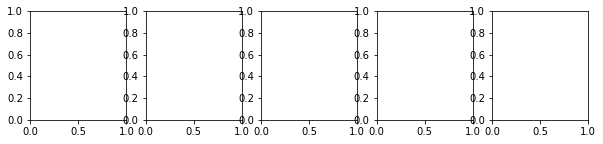

In [23]:
#Cantidad de batches en los que se divide el df
print(train_generator_Mapa.__len__())

#Comprobamos funcionamiento bach
X_batch, Y_batch = train_generator_Mapa.__getitem__(2582)

for i in range(0,batch_size):  # 4 es el maximo de conjunto de imagenes del batch creado
    # Seleccionamos ver la posicion numero 0 del batch creado
    comprobar_contenido(X_batch ,i)

## Autoencoder

### Keras


In [1]:
from tensorflow.keras.models import Model 
#from keras.layers import Input, ConvLSTM2D, TimeDistributed, BatchNormalization,MaxPooling2D, Dropout, Conv3D, MaxPooling3D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.regularizers import l2

2024-12-20 00:27:22.992871: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-20 00:27:23.000881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734650843.009878   54085 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734650843.012526   54085 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 00:27:23.022402: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [36]:
from keras.models import Model
from keras.layers import Input, TimeDistributed, Conv2D, MaxPooling2D, UpSampling2D, Cropping2D,ZeroPadding2D

def auto_encoder(input_shape_pov):
    # Capa de entrada para el autoencoder
    inputs = Input(shape=input_shape_pov)

    # Codificador
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(inputs)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same'))(x)
    encoded = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)

    # Decodificador
    x = TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same'))(encoded)
    x = TimeDistributed(UpSampling2D((2, 2)))(x)
    x = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(UpSampling2D((2, 2)))(x)
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(UpSampling2D((2, 2)))(x)
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(UpSampling2D((2, 2)))(x)
    x = TimeDistributed(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))(x)

    # Recortar la imagen (2,2)de alto (6,6)ancho 
    decoded = TimeDistributed(ZeroPadding2D(((4, 0), (4, 0))))(x)
    decoded = TimeDistributed(Cropping2D(((4, 4), (0, 0))))(decoded)
    
    return inputs, encoded , decoded


timesteps = 5
height = 188
width = 260
channels = 3
input_shape_pov = (timesteps, height, width, channels) # Modelo Pov
input_latente= Input(shape=(176, 256, 3))

inputs,encoded,decoded = auto_encoder(input_shape_pov)
model_autoencoder = Model(inputs, decoded)


In [37]:
timesteps = 5
height = 188
width = 260
channels = 3
input_shape_pov = (timesteps, height, width, channels) # Modelo Pov
input_latente= Input(shape=(176, 256, 3))

inputs,encoded,decoded = auto_encoder(input_shape_pov)
model_autoencoder = Model(inputs, decoded)

In [38]:
model_autoencoder.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_49 (InputLayer)     │ (None, 5, 188, 260, 3) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_434            │ (None, 5, 188, 260,    │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_435            │ (None, 5, 94, 130, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_436            │ (None, 5, 94, 130, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_437            │ (None, 5, 47, 65, 64)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_438            │ (None, 5, 47, 65, 128) │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_439            │ (None, 5, 23, 32, 128) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_440            │ (None, 5, 23, 32, 256) │       295,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_441            │ (None, 5, 12, 16, 256) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_442            │ (None, 5, 12, 16, 256) │       590,080 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_443            │ (None, 5, 24, 32, 256) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_444            │ (None, 5, 24, 32, 128) │       295,040 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_445            │ (None, 5, 48, 64, 128) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_446            │ (None, 5, 48, 64, 64)  │        73,792 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_447            │ (None, 5, 96, 128, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_448            │ (None, 5, 96, 128, 32) │        18,464 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_449            │ (None, 5, 192, 256,    │             0 │
│ (TimeDistributed)               │ 32)                    │             

 Total params: 1,366,659 (5.21 MB)

 Trainable params: 1,366,659 (5.21 MB)

 Non-trainable params: 0 (0.00 B)

### Pythorch

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Definir el modelo AutoEncoder
class AutoEncoder(nn.Module):
    def __init__(self, input_shape_pov):
        super(AutoEncoder, self).__init__()
        self.input_shape_pov = input_shape_pov

        # Codificador
        self.encoder = nn.Sequential(
            nn.Conv3d(input_shape_pov[0], 32, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1)),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            nn.Conv3d(32, 64, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1)),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            nn.Conv3d(64, 128, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1)),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            nn.Conv3d(128, 256, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1)),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=(0, 1, 1))
        )

        # Decodificador
        self.decoder = nn.Sequential(
            nn.Conv3d(256, 256, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1)),
            nn.ReLU(),
            nn.Upsample(scale_factor=(1, 2, 2), mode='trilinear', align_corners=True),
            nn.Conv3d(256, 128, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1)),
            nn.ReLU(),
            nn.Upsample(scale_factor=(1, 2, 2), mode='trilinear', align_corners=True),
            nn.Conv3d(128, 64, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1)),
            nn.ReLU(),
            nn.Upsample(scale_factor=(1, 2, 2), mode='trilinear', align_corners=True),
            nn.Conv3d(64, 32, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1)),
            nn.ReLU(),
            nn.Upsample(scale_factor=(1, 2, 2), mode='trilinear', align_corners=True),
            nn.Conv3d(32, 3, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1)),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        # Ajustar las dimensiones para recortar
        #decoded = decoded[:, :, :, 4:-1, :]  # Recortar (4,0) y (4,0) de la altura
        #decoded = decoded[:, :, :, :, 3:-4]  # Recortar (0,0) y (4,4) del ancho
        decoded = decoded[:, :, :, :188, :260]
        return encoded, decoded

In [25]:
# Definir la función de pérdida y el optimizador
input_shape_pov = (3, 5, 188, 260)  # Ejemplo de forma de entrada (canales, pasos de tiempo, alto, ancho)
model = AutoEncoder(input_shape_pov).to('cuda')  # Instancia el modelo y lo envía a la GPU
model.load_state_dict(torch.load('modelo_autoencoder_245_final.pth'))  # Cargar los pesos
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/tmp/ipykernel_9114/3484854297.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('modelo_autoencoder_245_final.pth'))  # Cargar los pesos


In [28]:
for i in range(train_generator_Mapa.__len__()):
    X_batch, Y_batch = train_generator_Mapa.__getitem__(i)
    X_batch = X_batch.transpose(0, 4, 1, 2, 3)  # Reorganizar las dimensiones
    Y_batch = Y_batch.transpose(0, 4, 1, 2, 3)  # Reorganizar las dimensiones
    print(X_batch.shape)
    print(Y_batch.shape)
    break

(20, 3, 5, 188, 260)
(20, 3, 5, 188, 260)


In [26]:
# Bucle de entrenamiento
num_epochs = 100
#best_validation_loss = float('inf')
best_validation_loss = 0.0266

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i in range(train_generator_Mapa.__len__()-1):
        input_images, target_images = train_generator_Mapa.__getitem__(i)
        print(f"-------Batch {i}/{train_generator_Mapa.__len__()}", end='\r')

        # Convertir los arrays de NumPy a tensores de PyTorch
        input_images = torch.tensor(input_images, dtype=torch.float32)
        target_images = torch.tensor(target_images, dtype=torch.float32)

        input_images = input_images.permute(0, 4, 1, 2, 3)  # Reorganizar las dimensiones
        target_images = target_images.permute(0, 4, 1, 2, 3)  # Reorganizar las dimensiones

        input_images = input_images.to('cuda').float() 
        target_images = target_images.to('cuda').float() 
        
        optimizer.zero_grad()
        _, outputs = model(input_images)
        loss = criterion(outputs, target_images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Promediar la pérdida
    train_loss = train_loss / len(train_generator_Mapa)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}", end='\r')

    model.eval()
    valid_loss = 0.0
    with torch.no_grad():

        for i in range(test_generator_Mapa.__len__()-1):
            input_images, target_images = test_generator_Mapa.__getitem__(i)

            # Convertir los arrays de NumPy a tensores de PyTorch
            input_images = torch.tensor(input_images, dtype=torch.float32)
            target_images = torch.tensor(target_images, dtype=torch.float32)

            input_images = input_images.permute(0, 4, 1, 2, 3)  # Reorganizar las dimensiones
            target_images = target_images.permute(0, 4, 1, 2, 3)  # Reorganizar las dimensiones
            
            input_images = input_images.to('cuda').float()  
            target_images = target_images.to('cuda').float()  

            _, outputs = model(input_images)
            loss = criterion(outputs, target_images)
            valid_loss += loss.item()

    # Promediar la pérdida de validación
    valid_loss = valid_loss / len(test_generator_Mapa)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')


    if valid_loss < best_validation_loss:
        best_validation_loss = valid_loss
        torch.save(model.state_dict(), 'modelo_autoencoder_245_final.pth')
        print(f'Modelo guardado en la época {epoch+1} con Valid Loss: {valid_loss:.4f}')

Epoch 1/100, Train Loss: 0.0279, Valid Loss: 0.0269
Modelo guardado en la época 1 con Valid Loss: 0.0269
Epoch 2/100, Train Loss: 0.0278, Valid Loss: 0.0269
Epoch 3/100, Train Loss: 0.0278, Valid Loss: 0.0269
Epoch 4/100, Train Loss: 0.0277, Valid Loss: 0.0268
Modelo guardado en la época 4 con Valid Loss: 0.0268
Epoch 5/100, Train Loss: 0.0277, Valid Loss: 0.0267
Modelo guardado en la época 5 con Valid Loss: 0.0267
Epoch 6/100, Train Loss: 0.0276, Valid Loss: 0.0267
Modelo guardado en la época 6 con Valid Loss: 0.0267
Epoch 7/100, Train Loss: 0.0276, Valid Loss: 0.0269
Epoch 8/100, Train Loss: 0.0276, Valid Loss: 0.0268
Epoch 9/100, Train Loss: 0.0276, Valid Loss: 0.0267
Epoch 10/100, Train Loss: 0.0276, Valid Loss: 0.0266
Modelo guardado en la época 10 con Valid Loss: 0.0266
Epoch 11/100, Train Loss: 0.0275, Valid Loss: 0.0266
Modelo guardado en la época 11 con Valid Loss: 0.0266
Epoch 12/100, Train Loss: 0.0275, Valid Loss: 0.0267


KeyboardInterrupt: 

In [26]:
def plot_images(input_tensor, output_tensor, timestep=0):
    # Mover a CPU y convertir a numpy
    input_image = input_tensor[0, :, timestep].permute(1, 2, 0).cpu().numpy()
    output_image = output_tensor[0, :, timestep].permute(1, 2, 0).cpu().numpy()

    # Crear las figuras
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(input_image)
    ax[0].set_title("Input Image")
    ax[0].axis("off")

    ax[1].imshow(output_image)
    ax[1].set_title("Reconstructed Image")
    ax[1].axis("off")

    plt.show()

In [31]:
model.eval()

for i in range(test_generator_Mapa.__len__()):
    input_images, target_images = test_generator_Mapa.__getitem__(i)

    # Convertir los arrays de NumPy a tensores de PyTorch
    input_images = torch.tensor(input_images, dtype=torch.float32)
    target_images = torch.tensor(target_images, dtype=torch.float32)

    input_images = input_images.permute(0, 4, 1, 2, 3)  # Reorganizar las dimensiones
    target_images = target_images.permute(0, 4, 1, 2, 3)  # Reorganizar las dimensiones

    input_images = input_images.to('cuda').float()
    target_images = target_images.to('cuda').float()

    features_map, _ = model(input_images)
    break

In [32]:
features_map.shape

torch.Size([25, 256, 5, 12, 17])

In [34]:
flattened = features_map.reshape(features_map.size(0), -1)

In [35]:
flattened.shape

torch.Size([25, 261120])

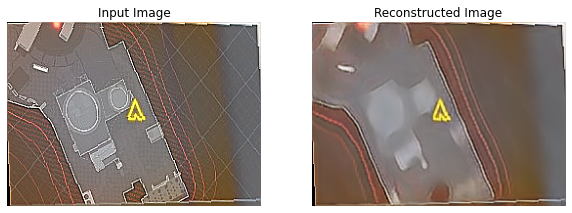

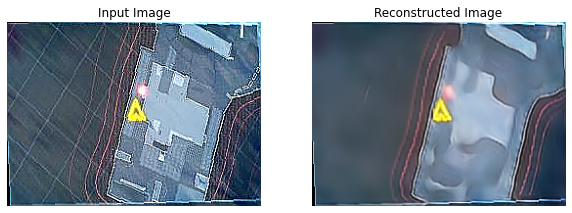

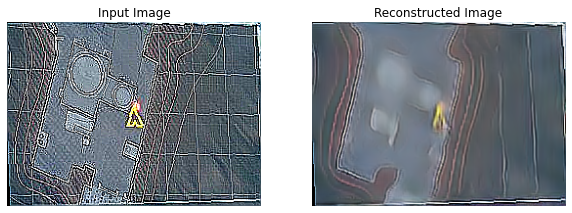

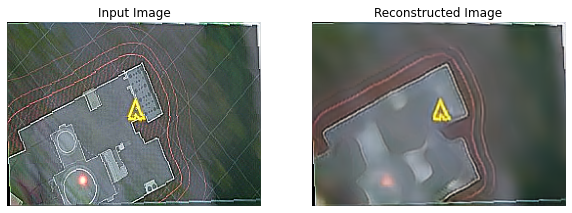

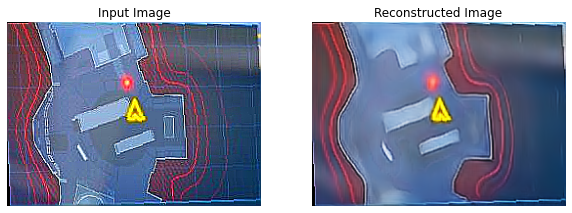

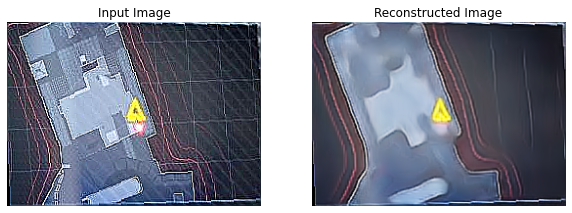

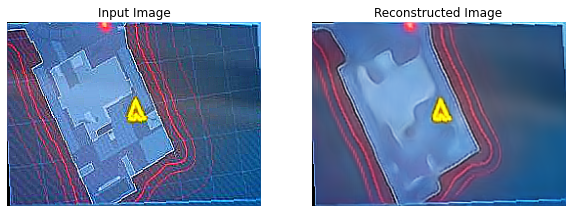

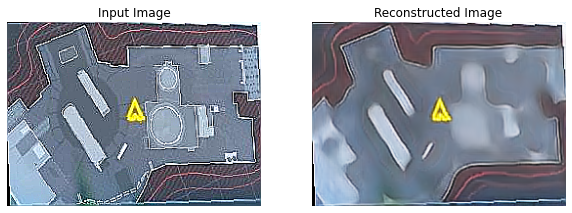

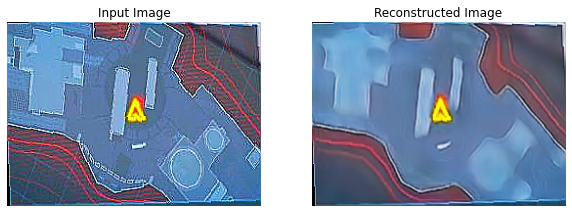

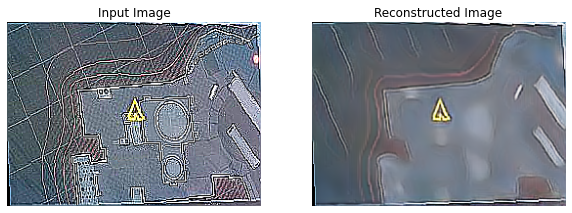

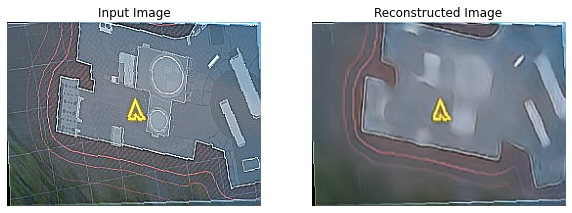

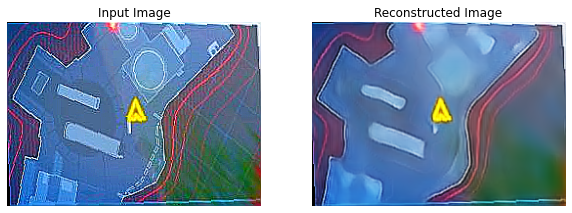

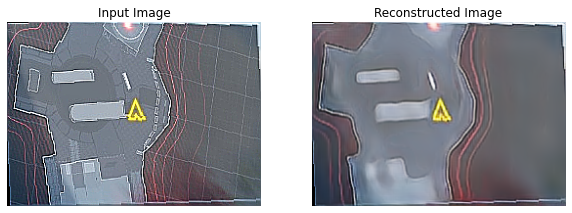

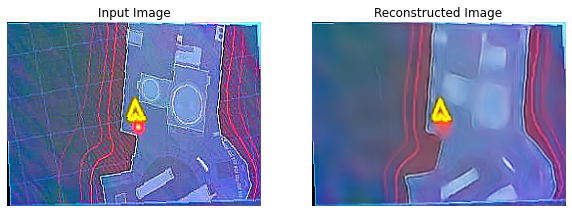

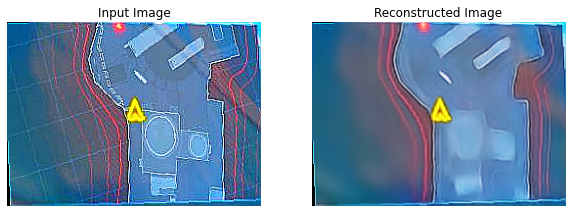

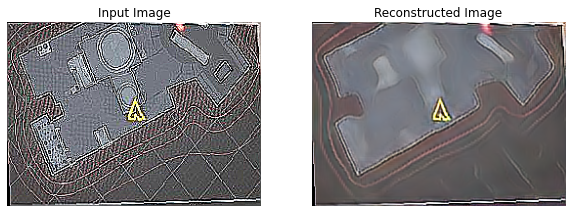

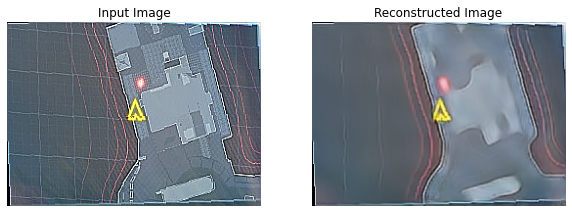

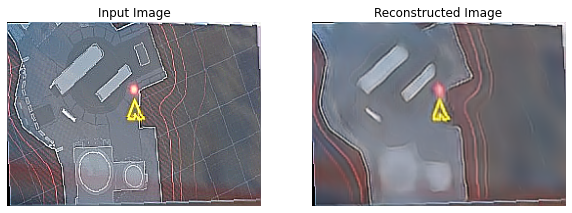

In [29]:
model.eval()
# Crear un array de 20 números aleatorios entre 0 y 100
random_numbers = np.random.randint(0, test_generator_Mapa.__len__(), size=20)
random_numbers_list = random_numbers.tolist()

# Generar la salida
with torch.no_grad():  # Desactiva el cálculo de gradientes
    for i in range(test_generator_Mapa.__len__()):
        input_images, target_images = test_generator_Mapa.__getitem__(i)

        # Convertir los arrays de NumPy a tensores de PyTorch
        input_images = torch.tensor(input_images, dtype=torch.float32)
        target_images = torch.tensor(target_images, dtype=torch.float32)

        input_images = input_images.permute(0, 4, 1, 2, 3)  # Reorganizar las dimensiones
        target_images = target_images.permute(0, 4, 1, 2, 3)  # Reorganizar las dimensiones

        input_images = input_images.to('cuda').float()
        target_images = target_images.to('cuda').float()

        _, outputs = model(input_images)

        if i in random_numbers:
            # Visualizar las imágenes
            plot_images(input_images, outputs, timestep=0) 

In [30]:
from tensorflow.keras.losses import MeanSquaredError

# Compilar el autoencoder
model_autoencoder.compile(optimizer='adam', loss=MeanSquaredError())
# Configurar EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min',restore_best_weights=True)
model_checkpoint = ModelCheckpoint('modelo_autoencoder_512.keras',monitor='val_loss',save_best_only=True,verbose=1)

In [31]:
import time

# Registro del tiempo de inicio
start_time = time.time()

# Entrenamiento Mini-Mapa
history = model_autoencoder.fit(train_generator_Mapa,
                    epochs=100,
                    validation_data=valid_generator_Mapa,
                    callbacks=[early_stopping,model_checkpoint]
                    )

model_autoencoder.save('modelo_autoencoder_512.h5')

# Registro del tiempo de finalización
end_time = time.time()

Epoch 1/100


I0000 00:00:1732832240.905824   43550 service.cc:146] XLA service 0x733144003500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732832240.905844   43550 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-11-28 23:17:21.176859: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-28 23:17:21.665101: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90400
2024-11-28 23:17:31.721163: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 72 bytes spill stores, 204 bytes spill loads

I0000 00:00:1732832251.738746   43550 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proces

1529/2138 ━━━━━━━━━━━━━━━━━━━━ 2:28 243ms/step - loss: 0.0237

2024-11-28 23:23:43.544444: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_9', 932 bytes spill stores, 1088 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 568 bytes spill stores, 808 bytes spill loads



2138/2138 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.0223
Epoch 1: val_loss improved from inf to 0.01543, saving model to modelo_autoencoder_512.keras
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 657s 300ms/step - loss: 0.0223 - val_loss: 0.0154
Epoch 2/100
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.0151
Epoch 2: val_loss improved from 0.01543 to 0.01452, saving model to modelo_autoencoder_512.keras
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 614s 287ms/step - loss: 0.0151 - val_loss: 0.0145
Epoch 3/100
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.0139
Epoch 3: val_loss improved from 0.01452 to 0.01267, saving model to modelo_autoencoder_512.keras
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 617s 289ms/step - loss: 0.0139 - val_loss: 0.0127
Epoch 4/100
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.0125
Epoch 4: val_loss did not improve from 0.01267
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 617s 288ms/step - loss: 0.0125 - val_loss: 0.0127
Epoch 5/100
2138/2138 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0

In [32]:
imagen_recostruida = model_autoencoder.predict(X_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [33]:
imagen_recostruida.shape

(10, 5, 188, 260, 3)

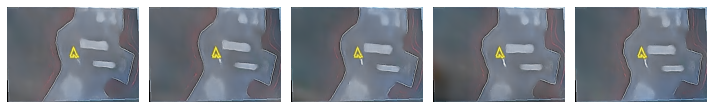

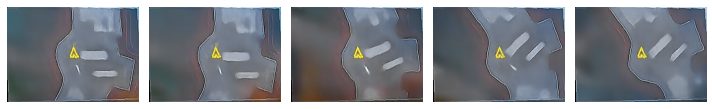

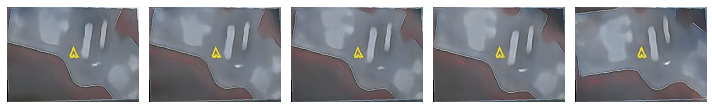

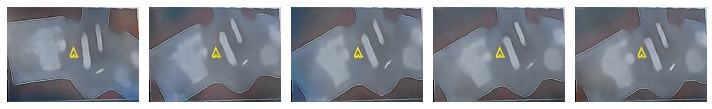

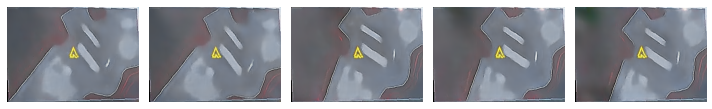

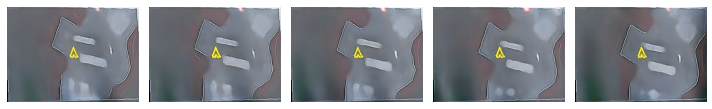

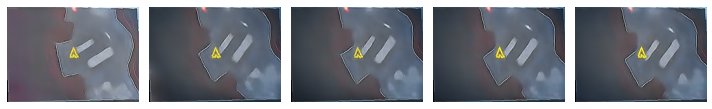

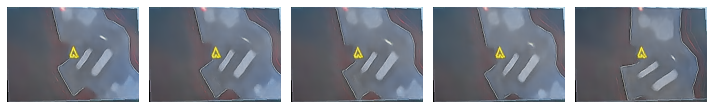

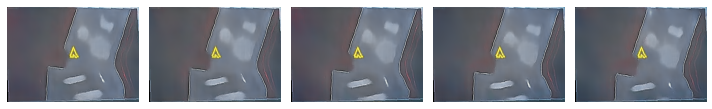

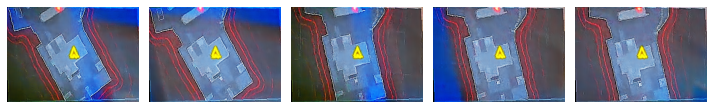

In [34]:
for i in range(0,batch_size):  # 4 es el maximo de conjunto de imagenes del batch creado
    # Seleccionamos ver la posicion numero 0 del batch creado
    comprobar_contenido(imagen_recostruida ,i)

In [41]:
# Modelo que utiliza solo el codificador
encoder_model = Model(inputs, encoded)

In [42]:
espacio_latente = encoder_model.predict(X_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


In [43]:
espacio_latente.shape

(10, 5, 6, 9, 512)

In [45]:
encoder_model.save("encoder_model.keras")

## Decision Transformer

In [2]:
from sklearn.utils import class_weight
import ast
import numpy as np
import math
import cv2
from PIL import Image, ImageEnhance ,ImageFilter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import tensorflow as tf
import logging


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-12-06 23:43:03.185678: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-06 23:43:03.194345: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733524983.203867  314624 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733524983.206705  314624 cuda_blas.cc:1418] Unable to register cuBL

In [2]:
# Ajusta el nivel de logs a ERROR para ocultar warnings y otros mensajes menos críticos
tf.get_logger().setLevel(logging.ERROR)

# Verificar dispositivos disponibles
if tf.test.gpu_device_name():
    print('GPU encontrada:', tf.test.gpu_device_name())
else:
    print("No se encontró GPU. Se utilizará la CPU.")

# Listar todas las GPU disponibles
gpus = tf.config.experimental.list_physical_devices('GPU')

# Configurar el crecimiento de memoria para cada GPU
if gpus:
    for gpu in gpus:
        print("Activada la asignacion de memoria gradual")
        tf.config.experimental.set_memory_growth(gpu, True)

GPU encontrada: /device:GPU:0
Activada la asignacion de memoria gradual


I0000 00:00:1733498105.736018  575380 gpu_device.cc:2022] Created device /device:GPU:0 with 6840 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1
I0000 00:00:1733498105.737234  575380 gpu_device.cc:2022] Created device /device:GPU:0 with 6840 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1


In [3]:
from tensorflow.keras.models import load_model


FILAS_MAX = 30
encoder_model = load_model('encoder_model.keras')

def cargar_df(filas_max):
    # Cargar el DataFrame desde un archivo .pkl
    df = pd.read_pickle('df_augementado.pkl')
    # Encontrar el valor máximo de la columna 'orden' para cada 'id'
    maximos_orden_por_id = df.groupby('id')['orden'].max()

    # Filtrar los 'id' cuyo valor máximo de 'orden' es mayor a filas_max
    ids_mayor_30 = maximos_orden_por_id[maximos_orden_por_id > filas_max].index.tolist()

    return df[~df['id'].isin(ids_mayor_30)] #Eliminamos todos los que su orden en mayor de 30

def preprocesado_df(df):
    # Convertir la columna de tipo object a listas de enteros
    df['etiqueta'] = df['etiqueta'].apply(ast.literal_eval)
    # Eliminamos las filas donde 'mouse_final' sea igual a [0, 4]
    filtro = df['etiqueta'].apply(lambda x: x[1] == 4)
    df = df[~filtro]
    # Crear un filtro booleano para las filas que cumplen la condición
    condicion = df['etiqueta'].apply(lambda x: x[1] == 2)
    # Juntamos las pulsaciones y tecla en una columna
    #x_positions_2 = df['etiqueta'].apply(lambda x: str(x[0])+str(x[1]))
    x_positions_2 = df['etiqueta'].apply(lambda x: str(x[1]))
    df['etiqueta'] = x_positions_2
    # Modificar solo las filas que cumplen con la condición
    #df.loc[condicion, 'etiqueta'] = df.loc[condicion, 'etiqueta'].apply(lambda x: "12")
    return df

def aplicar_one_hot_balanceo(df,columa):
    # Crear un DataFrame con las columnas de one-hot encoding
    one_hot_df = pd.get_dummies(df[columa], prefix='label')

    # Unir el DataFrame original con el DataFrame de one-hot encoding
    df = pd.concat([df, one_hot_df], axis=1)

    # Balanceamos los pesos para el entrenamiento
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(df[columa]),
        y=df[columa]
    )

    # Crear un diccionario de pesos para las clases
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    #Eliminamos la columna original
    df = df.drop(columa, axis=1)
    return df , class_weight_dict

I0000 00:00:1733498114.766710  575380 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6840 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1


In [4]:
df = cargar_df(FILAS_MAX)
df , pesos_train = aplicar_one_hot_balanceo(preprocesado_df(df),"etiqueta")

/tmp/ipykernel_575380/2150699650.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['etiqueta'] = x_positions_2


In [7]:
df

id  orden                                            mapa_01  \
0     0      1  datos/grabacion/mapa_augmentation/imagen_14427...   
1     0      2  datos/grabacion/mapa_augmentation/imagen_14428...   
2     0      3  datos/grabacion/mapa_augmentation/imagen_14429...   
3     0      4  datos/grabacion/mapa_augmentation/imagen_14430...   
4     0      5  datos/grabacion/mapa_augmentation/imagen_14431...   
..   ..    ...                                                ...   
288  20      2  datos/grabacion/mapa_augmentation/imagen_14808...   
289  20      3  datos/grabacion/mapa_augmentation/imagen_14809...   
290  20      4  datos/grabacion/mapa_augmentation/imagen_14810...   
291  20      5  datos/grabacion/mapa_augmentation/imagen_14811...   
292  20      6  datos/grabacion/mapa_augmentation/imagen_14812...   

                                               mapa_02  \
0    datos/grabacion/mapa_augmentation/imagen_14427...   
1    datos/grabacion/mapa_augmentation/imagen_14428...   
2    datos/grabacion/mapa_augmentation/imagen_14429...   
3    datos/grabacion/mapa_augmentation/imagen_14430...   
4    datos/grabacion/mapa_augmentation/imagen_14431...   
..                                                 ...   
288  datos/grabacion/mapa_augmentation/imagen_14808...   
289  datos/grabacion/mapa_augmentation/imagen_14809...   
290  datos/grabacion/mapa_augmentation/imagen_14810...   
291  datos/grabacion/mapa_augmentation/imagen_14811...   
292  datos/grabacion/mapa_augmentation/imagen_14812...   

                                               mapa_03  \
0    datos/grabacion/mapa_augmentation/imagen_14427...   
1    datos/grabacion/mapa_augmentation/imagen_14428...   
2    datos/grabacion/mapa_augmentation/imagen_14429...   
3    datos/grabacion/mapa_augmentation/imagen_14430...   
4    datos/grabacion/mapa_augmentation/imagen_14431...   
..                                                 ...   
288  datos/grabacion/mapa_augmentation/imagen_14808...   
289  datos/grabacion/mapa_augmentation/imagen_14809...   
290  datos/grabacion/mapa_augmentation/imagen_14810...   
291  datos/grabacion/mapa_augmentation/imagen_14811...   
292  datos/grabacion/mapa_augmentation/imagen_14812...   

                                               mapa_04  \
0    datos/grabacion/mapa_augmentation/imagen_14427...   
1    datos/grabacion/mapa_augmentation/imagen_14428...   
2    datos/grabacion/mapa_augmentation/imagen_14429...   
3    datos/grabacion/mapa_augmentation/imagen_14430...   
4    datos/grabacion/mapa_augmentation/imagen_14431...   
..                                                 ...   
288  datos/grabacion/mapa_augmentation/imagen_14808...   
289  datos/grabacion/mapa_augmentation/imagen_14809...   
290  datos/grabacion/mapa_augmentation/imagen_14810...   
291  datos/grabacion/mapa_augmentation/imagen_14811...   
292  datos/grabacion/mapa_augmentation/imagen_14812...   

                                               mapa_05  reward  label_0  \
0    datos/grabacion/mapa_augmentation/imagen_14427...   0.965        0   
1    datos/grabacion/mapa_augmentation/imagen_14428...   0.540        0   
2    datos/grabacion/mapa_augmentation/imagen_14429...   0.560        1   
3    datos/grabacion/mapa_augmentation/imagen_14430...   0.605        0   
4    datos/grabacion/mapa_augmentation/imagen_14431...   0.605        0   
..                                                 ...     ...      ...   
288  datos/grabacion/mapa_augmentation/imagen_14808...   0.885        0   
289  datos/grabacion/mapa_augmentation/imagen_14809...   0.425        0   
290  datos/grabacion/mapa_augmentation/imagen_14810...   0.545        0   
291  datos/grabacion/mapa_augmentation/imagen_14811...   0.545        0   
292  datos/grabacion/mapa_augmentation/imagen_14812...   0.605        0   

     label_1  label_2                                            flatten  
0          1        0  [0.0, 0.010752273723483086, 0.0, 0.00355310412...  
1          0        1  [0.0, 0.024

In [5]:
# Crear un diccionario de mapeo de los IDs actuales a los nuevos consecutivos
# Primero, obtenemos los valores únicos de ID y les asignamos nuevos valores consecutivos
nuevos_ids = {old_id: new_id for new_id, old_id in enumerate(sorted(df['id'].unique()))}
# Aplicamos el mapeo para reemplazar los IDs en el DataFrame
df['id'] = df['id'].map(nuevos_ids)
df = df.reset_index(drop=True)

In [7]:
df.tail(10)

id orden                                            mapa_01  \
46872  3595     5  datos/grabacion/mapa_augmentation/imagen_14802...   
46873  3595     6  datos/grabacion/mapa_augmentation/imagen_14803...   
46874  3595     7  datos/grabacion/mapa_augmentation/imagen_14804...   
46875  3595     8  datos/grabacion/mapa_augmentation/imagen_14805...   
46876  3596     1  datos/grabacion/mapa_augmentation/imagen_14807...   
46877  3596     2  datos/grabacion/mapa_augmentation/imagen_14808...   
46878  3596     3  datos/grabacion/mapa_augmentation/imagen_14809...   
46879  3596     4  datos/grabacion/mapa_augmentation/imagen_14810...   
46880  3596     5  datos/grabacion/mapa_augmentation/imagen_14811...   
46881  3596     6  datos/grabacion/mapa_augmentation/imagen_14812...   

                                                 mapa_02  \
46872  datos/grabacion/mapa_augmentation/imagen_14802...   
46873  datos/grabacion/mapa_augmentation/imagen_14803...   
46874  datos/grabacion/mapa_augmentation/imagen_14804...   
46875  datos/grabacion/mapa_augmentation/imagen_14805...   
46876  datos/grabacion/mapa_augmentation/imagen_14807...   
46877  datos/grabacion/mapa_augmentation/imagen_14808...   
46878  datos/grabacion/mapa_augmentation/imagen_14809...   
46879  datos/grabacion/mapa_augmentation/imagen_14810...   
46880  datos/grabacion/mapa_augmentation/imagen_14811...   
46881  datos/grabacion/mapa_augmentation/imagen_14812...   

                                                 mapa_03  \
46872  datos/grabacion/mapa_augmentation/imagen_14802...   
46873  datos/grabacion/mapa_augmentation/imagen_14803...   
46874  datos/grabacion/mapa_augmentation/imagen_14804...   
46875  datos/grabacion/mapa_augmentation/imagen_14805...   
46876  datos/grabacion/mapa_augmentation/imagen_14807...   
46877  datos/grabacion/mapa_augmentation/imagen_14808...   
46878  datos/grabacion/mapa_augmentation/imagen_14809...   
46879  datos/grabacion/mapa_augmentation/imagen_14810...   
46880  datos/grabacion/mapa_augmentation/imagen_14811...   
46881  datos/grabacion/mapa_augmentation/imagen_14812...   

                                                 mapa_04  \
46872  datos/grabacion/mapa_augmentation/imagen_14802...   
46873  datos/grabacion/mapa_augmentation/imagen_14803...   
46874  datos/grabacion/mapa_augmentation/imagen_14804...   
46875  datos/grabacion/mapa_augmentation/imagen_14805...   
46876  datos/grabacion/mapa_augmentation/imagen_14807...   
46877  datos/grabacion/mapa_augmentation/imagen_14808...   
46878  datos/grabacion/mapa_augmentation/imagen_14809...   
46879  datos/grabacion/mapa_augmentation/imagen_14810...   
46880  datos/grabacion/mapa_augmentation/imagen_14811...   
46881  datos/grabacion/mapa_augmentation/imagen_14812...   

                                                 mapa_05  reward  label_0  \
46872  datos/grabacion/mapa_augmentation/imagen_14802...   0.545        0   
46873  datos/grabacion/mapa_augmentation/imagen_14803...   0.680        1   
46874  datos/grabacion/mapa_augmentation/imagen_14804...   0.555        0   
46875  datos/grabacion/mapa_augmentation/imagen_14805...   0.765        0   
46876  datos/grabacion/mapa_augmentation/imagen_14807...   0.930        0   
46877  datos/grabacion/mapa_augmentation/imagen_14808...   0.885        0   
46878  datos/grabacion/mapa_augmentation/imagen_14809...   0.425        0   
46879  datos/grabacion/mapa_augmentation/imagen_14810...   0.545        0   
46880  datos/grabacion/mapa_augmentation/imagen_14811...   0.545        0   
46881  datos/grabacion/mapa_augmentation/imagen_14812...   0.605        0   

       label_1  label_2  
46872        1        0  
46873        0        0  
46874        1        0  
46875        0        1  
46876        0        1  
46877        0        1  
46878        0        1  
46879        0        1  
46880        0        1  
46881        0        1

In [8]:
# Filtrar las filas donde el ID esté entre 3586 y 3596 (inclusive)
filtered_df = df[(df['id'] >= 3576) & (df['id'] <= 3596)]

In [9]:
filtered_df

id orden                                            mapa_01  \
46589  3576     1  datos/grabacion/mapa_augmentation/imagen_14427...   
46590  3576     2  datos/grabacion/mapa_augmentation/imagen_14428...   
46591  3576     3  datos/grabacion/mapa_augmentation/imagen_14429...   
46592  3576     4  datos/grabacion/mapa_augmentation/imagen_14430...   
46593  3576     5  datos/grabacion/mapa_augmentation/imagen_14431...   
...     ...   ...                                                ...   
46877  3596     2  datos/grabacion/mapa_augmentation/imagen_14808...   
46878  3596     3  datos/grabacion/mapa_augmentation/imagen_14809...   
46879  3596     4  datos/grabacion/mapa_augmentation/imagen_14810...   
46880  3596     5  datos/grabacion/mapa_augmentation/imagen_14811...   
46881  3596     6  datos/grabacion/mapa_augmentation/imagen_14812...   

                                                 mapa_02  \
46589  datos/grabacion/mapa_augmentation/imagen_14427...   
46590  datos/grabacion/mapa_augmentation/imagen_14428...   
46591  datos/grabacion/mapa_augmentation/imagen_14429...   
46592  datos/grabacion/mapa_augmentation/imagen_14430...   
46593  datos/grabacion/mapa_augmentation/imagen_14431...   
...                                                  ...   
46877  datos/grabacion/mapa_augmentation/imagen_14808...   
46878  datos/grabacion/mapa_augmentation/imagen_14809...   
46879  datos/grabacion/mapa_augmentation/imagen_14810...   
46880  datos/grabacion/mapa_augmentation/imagen_14811...   
46881  datos/grabacion/mapa_augmentation/imagen_14812...   

                                                 mapa_03  \
46589  datos/grabacion/mapa_augmentation/imagen_14427...   
46590  datos/grabacion/mapa_augmentation/imagen_14428...   
46591  datos/grabacion/mapa_augmentation/imagen_14429...   
46592  datos/grabacion/mapa_augmentation/imagen_14430...   
46593  datos/grabacion/mapa_augmentation/imagen_14431...   
...                                                  ...   
46877  datos/grabacion/mapa_augmentation/imagen_14808...   
46878  datos/grabacion/mapa_augmentation/imagen_14809...   
46879  datos/grabacion/mapa_augmentation/imagen_14810...   
46880  datos/grabacion/mapa_augmentation/imagen_14811...   
46881  datos/grabacion/mapa_augmentation/imagen_14812...   

                                                 mapa_04  \
46589  datos/grabacion/mapa_augmentation/imagen_14427...   
46590  datos/grabacion/mapa_augmentation/imagen_14428...   
46591  datos/grabacion/mapa_augmentation/imagen_14429...   
46592  datos/grabacion/mapa_augmentation/imagen_14430...   
46593  datos/grabacion/mapa_augmentation/imagen_14431...   
...                                                  ...   
46877  datos/grabacion/mapa_augmentation/imagen_14808...   
46878  datos/grabacion/mapa_augmentation/imagen_14809...   
46879  datos/grabacion/mapa_augmentation/imagen_14810...   
46880  datos/grabacion/mapa_augmentation/imagen_14811...   
46881  datos/grabacion/mapa_augmentation/imagen_14812...   

                                                 mapa_05  reward  label_0  \
46589  datos/grabacion/mapa_augmentation/imagen_14427...   0.965        0   
46590  datos/grabacion/mapa_augmentation/imagen_14428...   0.540        0   
46591  datos/grabacion/mapa_augmentation/imagen_14429...   0.560        1   
46592  datos/grabacion/mapa_augmentation/imagen_14430...   0.605        0   
46593  datos/grabacion/mapa_augmentation/imagen_14431...   0.605        0   
...                                                  ...     ...      ...   
46877  datos/grabacion/mapa_augmentation/imagen_14808...   0.885        0   
46878  datos/grabacion/mapa_augmentation/imagen_14809...   0.425        0   
46879  datos/grabacion/mapa_augmentation/imagen_14810...   0.545        0   
46880  datos/grabacion/mapa_augmentation/imagen_14811...   0.545        0   
46881  datos/grabacion/mapa_augmentation/imagen_14812...   0.605        0   

       label_1  label_2  
46589        1        0  
4659

In [10]:
# Eliminar esas filas del DataFrame original
df_train = df.drop(df[(df['id'] >= 3576) & (df['id'] <= 3596)].index)
# Reiniciar el índice del train
df_train = df_train.reset_index(drop=True)
# Reiniciar el índice del valid
filtered_df = filtered_df.reset_index(drop=True)

In [11]:
filtered_df.head(10)

id orden                                            mapa_01  \
0  3576     1  datos/grabacion/mapa_augmentation/imagen_14427...   
1  3576     2  datos/grabacion/mapa_augmentation/imagen_14428...   
2  3576     3  datos/grabacion/mapa_augmentation/imagen_14429...   
3  3576     4  datos/grabacion/mapa_augmentation/imagen_14430...   
4  3576     5  datos/grabacion/mapa_augmentation/imagen_14431...   
5  3576     6  datos/grabacion/mapa_augmentation/imagen_14432...   
6  3576     7  datos/grabacion/mapa_augmentation/imagen_14433...   
7  3576     8  datos/grabacion/mapa_augmentation/imagen_14434...   
8  3576     9  datos/grabacion/mapa_augmentation/imagen_14435...   
9  3576    10  datos/grabacion/mapa_augmentation/imagen_14436...   

                                             mapa_02  \
0  datos/grabacion/mapa_augmentation/imagen_14427...   
1  datos/grabacion/mapa_augmentation/imagen_14428...   
2  datos/grabacion/mapa_augmentation/imagen_14429...   
3  datos/grabacion/mapa_augmentation/imagen_14430...   
4  datos/grabacion/mapa_augmentation/imagen_14431...   
5  datos/grabacion/mapa_augmentation/imagen_14432...   
6  datos/grabacion/mapa_augmentation/imagen_14433...   
7  datos/grabacion/mapa_augmentation/imagen_14434...   
8  datos/grabacion/mapa_augmentation/imagen_14435...   
9  datos/grabacion/mapa_augmentation/imagen_14436...   

                                             mapa_03  \
0  datos/grabacion/mapa_augmentation/imagen_14427...   
1  datos/grabacion/mapa_augmentation/imagen_14428...   
2  datos/grabacion/mapa_augmentation/imagen_14429...   
3  datos/grabacion/mapa_augmentation/imagen_14430...   
4  datos/grabacion/mapa_augmentation/imagen_14431...   
5  datos/grabacion/mapa_augmentation/imagen_14432...   
6  datos/grabacion/mapa_augmentation/imagen_14433...   
7  datos/grabacion/mapa_augmentation/imagen_14434...   
8  datos/grabacion/mapa_augmentation/imagen_14435...   
9  datos/grabacion/mapa_augmentation/imagen_14436...   

                                             mapa_04  \
0  datos/grabacion/mapa_augmentation/imagen_14427...   
1  datos/grabacion/mapa_augmentation/imagen_14428...   
2  datos/grabacion/mapa_augmentation/imagen_14429...   
3  datos/grabacion/mapa_augmentation/imagen_14430...   
4  datos/grabacion/mapa_augmentation/imagen_14431...   
5  datos/grabacion/mapa_augmentation/imagen_14432...   
6  datos/grabacion/mapa_augmentation/imagen_14433...   
7  datos/grabacion/mapa_augmentation/imagen_14434...   
8  datos/grabacion/mapa_augmentation/imagen_14435...   
9  datos/grabacion/mapa_augmentation/imagen_14436...   

                                             mapa_05  reward  label_0  \
0  datos/grabacion/mapa_augmentation/imagen_14427...   0.965        0   
1  datos/grabacion/mapa_augmentation/imagen_14428...   0.540        0   
2  datos/grabacion/mapa_augmentation/imagen_14429...   0.560        1   
3  datos/grabacion/mapa_augmentation/imagen_14430...   0.605        0   
4  datos/grabacion/mapa_augmentation/imagen_14431...   0.605        0   
5  datos/grabacion/mapa_augmentation/imagen_14432...   0.665        1   
6  datos/grabacion/mapa_augmentation/imagen_14433...   0.605        0   
7  datos/grabacion/mapa_augmentation/imagen_14434...   0.745        0   
8  datos/grabacion/mapa_augmentation/imagen_14435...   0.845        1   
9  datos/grabacion/mapa_augmentation/imagen_14436...   0.715        1   

   label_1  label_2  
0        1        0  
1        0        1  
2        0        0  
3        0        1  
4        1        0  
5        0        0  
6        0        1  
7        0        1  
8        0        0  
9        0        0

In [12]:
df_train.tail(10)

id orden                                            mapa_01  \
46579  3574    11  datos/grabacion/mapa_augmentation/imagen_14415...   
46580  3574    12  datos/grabacion/mapa_augmentation/imagen_14416...   
46581  3574    13  datos/grabacion/mapa_augmentation/imagen_14417...   
46582  3575     1  datos/grabacion/mapa_augmentation/imagen_14419...   
46583  3575     2  datos/grabacion/mapa_augmentation/imagen_14420...   
46584  3575     3  datos/grabacion/mapa_augmentation/imagen_14421...   
46585  3575     4  datos/grabacion/mapa_augmentation/imagen_14422...   
46586  3575     5  datos/grabacion/mapa_augmentation/imagen_14423...   
46587  3575     6  datos/grabacion/mapa_augmentation/imagen_14424...   
46588  3575     7  datos/grabacion/mapa_augmentation/imagen_14425...   

                                                 mapa_02  \
46579  datos/grabacion/mapa_augmentation/imagen_14415...   
46580  datos/grabacion/mapa_augmentation/imagen_14416...   
46581  datos/grabacion/mapa_augmentation/imagen_14417...   
46582  datos/grabacion/mapa_augmentation/imagen_14419...   
46583  datos/grabacion/mapa_augmentation/imagen_14420...   
46584  datos/grabacion/mapa_augmentation/imagen_14421...   
46585  datos/grabacion/mapa_augmentation/imagen_14422...   
46586  datos/grabacion/mapa_augmentation/imagen_14423...   
46587  datos/grabacion/mapa_augmentation/imagen_14424...   
46588  datos/grabacion/mapa_augmentation/imagen_14425...   

                                                 mapa_03  \
46579  datos/grabacion/mapa_augmentation/imagen_14415...   
46580  datos/grabacion/mapa_augmentation/imagen_14416...   
46581  datos/grabacion/mapa_augmentation/imagen_14417...   
46582  datos/grabacion/mapa_augmentation/imagen_14419...   
46583  datos/grabacion/mapa_augmentation/imagen_14420...   
46584  datos/grabacion/mapa_augmentation/imagen_14421...   
46585  datos/grabacion/mapa_augmentation/imagen_14422...   
46586  datos/grabacion/mapa_augmentation/imagen_14423...   
46587  datos/grabacion/mapa_augmentation/imagen_14424...   
46588  datos/grabacion/mapa_augmentation/imagen_14425...   

                                                 mapa_04  \
46579  datos/grabacion/mapa_augmentation/imagen_14415...   
46580  datos/grabacion/mapa_augmentation/imagen_14416...   
46581  datos/grabacion/mapa_augmentation/imagen_14417...   
46582  datos/grabacion/mapa_augmentation/imagen_14419...   
46583  datos/grabacion/mapa_augmentation/imagen_14420...   
46584  datos/grabacion/mapa_augmentation/imagen_14421...   
46585  datos/grabacion/mapa_augmentation/imagen_14422...   
46586  datos/grabacion/mapa_augmentation/imagen_14423...   
46587  datos/grabacion/mapa_augmentation/imagen_14424...   
46588  datos/grabacion/mapa_augmentation/imagen_14425...   

                                                 mapa_05  reward  label_0  \
46579  datos/grabacion/mapa_augmentation/imagen_14415...   0.800        1   
46580  datos/grabacion/mapa_augmentation/imagen_14416...   0.815        1   
46581  datos/grabacion/mapa_augmentation/imagen_14417...   0.745        1   
46582  datos/grabacion/mapa_augmentation/imagen_14419...   0.945        0   
46583  datos/grabacion/mapa_augmentation/imagen_14420...   0.565        1   
46584  datos/grabacion/mapa_augmentation/imagen_14421...   0.515        0   
46585  datos/grabacion/mapa_augmentation/imagen_14422...   0.535        0   
46586  datos/grabacion/mapa_augmentation/imagen_14423...   0.865        0   
46587  datos/grabacion/mapa_augmentation/imagen_14424...   0.550        0   
46588  datos/grabacion/mapa_augmentation/imagen_14425...   0.740        1   

       label_1  label_2  
46579        0        0  
46580        0        0  
46581        0        0  
46582        0        1  
46583        0        0  
46584        1        0  
46585        0        1  
46586        0        1  
46587        0        1  
46588        0        0

In [13]:
def _flattenarImagen2(df,contenido):
    df_new = pd.DataFrame(columns=list(df.columns) + ['flatten'])

    for index, row in df.iterrows():
        fila_copiada = row.copy()

        fila_copiada['id'] = row['id']
        fila_copiada['orden'] = row['orden']

        fila_copiada[contenido+'_01'] = row[contenido+'_01']
        fila_copiada[contenido+'_02'] = row[contenido+'_02']
        fila_copiada[contenido+'_03'] = row[contenido+'_03']
        fila_copiada[contenido+'_04'] = row[contenido+'_04']
        fila_copiada[contenido+'_05'] = row[contenido+'_05']

        fila_copiada['reward'] = row['reward']

        fila_copiada['label_0'] = row['label_0']
        fila_copiada['label_1'] = row['label_1']
        fila_copiada['label_2'] = row['label_2']

        fila_copiada['flatten'] = [_obtener_fila(row).flatten()]
        # Agregar la fila modificada al nuevo DataFrame
        df_new = pd.concat([df_new, pd.DataFrame([fila_copiada])], ignore_index=True)
    return df_new

def _flattenarImagen(df, contenido, output_file):
    # Crear un archivo CSV con las columnas iniciales si no existe
    columns = list(df.columns) + ['flatten']
    with open(output_file, mode='w') as f:
        pd.DataFrame(columns=columns).to_csv(f, index=False)

    # Procesar las filas una por una y escribir en el archivo CSV
    for index, row in df.iterrows():
        fila_copiada = {
            'id': row['id'],
            'orden': row['orden'],
            contenido + '_01': row[contenido + '_01'],
            contenido + '_02': row[contenido + '_02'],
            contenido + '_03': row[contenido + '_03'],
            contenido + '_04': row[contenido + '_04'],
            contenido + '_05': row[contenido + '_05'],
            'reward': row['reward'],
            'label_0': row['label_0'],
            'label_1': row['label_1'],
            'label_2': row['label_2'],
            'flatten': _obtener_fila(row).flatten().tolist(),  # Convertir a lista para serializar en CSV
        }

        # Convertir a DataFrame temporal y escribir en modo 'append'
        pd.DataFrame([fila_copiada]).to_csv(output_file, mode='a', header=False, index=False)


def _preprocesado(imagen):
    ancho, alto = imagen.size
    imagen = imagen.rotate(2.5, expand=True)
    imagen = imagen.crop((5, 12, ancho - 35, alto-25))
    return np.array(imagen) / 255.0

def _embedding(video,):
    global encoder_model
    video = np.expand_dims(video, axis=0)  # Esto agregará una nueva dimensión al principio
    return encoder_model.predict(video,verbose=0) 

def _obtener_fila(row):
    frames = []
    frames.append(_preprocesado(Image.open("../" + row[2])))
    frames.append(_preprocesado(Image.open("../" + row[3])))
    frames.append(_preprocesado(Image.open("../" + row[4])))
    frames.append(_preprocesado(Image.open("../" + row[5])))
    frames.append(_preprocesado(Image.open("../" + row[6])))
    video = np.stack(frames, axis=0)
    return _embedding(video)

In [14]:
output_file = "df_train_flatten.csv"
_flattenarImagen(df_train, "mapa", output_file)

I0000 00:00:1733498299.573195  576121 service.cc:148] XLA service 0x732c00004fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733498299.573218  576121 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-12-06 16:18:19.611044: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733498299.689838  576121 cuda_dnn.cc:529] Loaded cuDNN version 90501
2024-12-06 16:18:20.374437: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[1,32,188,260]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,3,188,260]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":

In [15]:
output_file = "df_valid_flatten.csv"
_flattenarImagen(filtered_df, "mapa", output_file)

In [ ]:
import torch
import torch.nn as nn
from transformers import PreTrainedModel, GPT2Config, GPT2Model

class TransformerBehaviorCloning(PreTrainedModel):
    def __init__(self, state_dim, act_dim, hidden_size=128, n_layer=4, n_head=4, max_seq_len=31):
        config = GPT2Config(
            n_embd=hidden_size,
            n_layer=n_layer,
            n_head=n_head,
            n_positions=max_seq_len,
            n_ctx=max_seq_len,
            vocab_size=1  # No necesitamos un vocabulario real, solo embeddings.
        )
        super().__init__(config)

        # Transformer base
        self.transformer = GPT2Model(config)

        # Proyección lineal para mapear el hidden state a las dimensiones de acción
        self.action_head = nn.Linear(hidden_size, act_dim)

        # Embedding para los estados (puedes agregar más preprocesamiento si es necesario)
        self.state_embedding = nn.Linear(state_dim, hidden_size)

    def forward(self, states, attention_mask=None):
        # Crear embeddings para los estados
        state_embeddings = self.state_embedding(states)

        # Pasar a través del Transformer
        transformer_outputs = self.transformer(
            inputs_embeds=state_embeddings,
            attention_mask=attention_mask
        )

        # Tomar el último hidden state
        hidden_states = transformer_outputs.last_hidden_state

        # Predecir acciones
        action_preds = self.action_head(hidden_states)

        return action_preds

In [30]:
lista = df_new["flatten"][0]

In [33]:
array = np.array(lista)

In [39]:
array.shape

(1, 138240)

In [37]:
array[0].shape

(138240,)

In [28]:
def buscar_id(chunk_iter, id):
    resultados = []  # Lista para almacenar las filas encontradas
    no_matches_count = 0  # Contador de chunks sin coincidencias
    found_any = False  # Bandera para indicar si hemos encontrado al menos una coincidencia

    # Procesar cada trozo de datos
    for chunk in chunk_iter:
        # Filtrar las filas que coinciden con el id deseado
        filas_filtradas = chunk[chunk['id'] == id]
        
        if not filas_filtradas.empty:
            # Si encontramos filas, agregarlas a la lista y reiniciar el contador
            resultados.append(filas_filtradas)
            no_matches_count = 0
            found_any = True
        else:
            # Si no encontramos coincidencias, aumentar el contador
            no_matches_count += 1

        # Si no encontramos coincidencias en dos chunks seguidos después de encontrar resultados, detener la búsqueda
        if found_any and no_matches_count == 2:
            break

    # Si no encontramos ningún resultado, devolver None
    if not resultados:
        return None
    
    # Concatenar y devolver los resultados encontrados
    return pd.concat(resultados)


In [14]:
hola = pd.read_csv('output_flatten.csv', nrows=100)

In [8]:
hola.shape

(100, 12)

In [15]:
for i, (_, row) in enumerate(hola.iterrows()):
    break

In [16]:
row

id                                                         0
orden                                                      1
mapa_01    datos/grabacion/mini_mapa/mini_mapa_07-20-03-2...
mapa_02    datos/grabacion/mini_mapa/mini_mapa_07-20-03-2...
mapa_03    datos/grabacion/mini_mapa/mini_mapa_07-20-03-2...
mapa_04    datos/grabacion/mini_mapa/mini_mapa_07-20-03-2...
mapa_05    datos/grabacion/mini_mapa/mini_mapa_07-20-03-2...
reward                                                  0.58
label_0                                                    0
label_1                                                    0
label_2                                                    1
flatten    [0.0, 0.03436035290360451, 0.0, 0.0, 0.0, 0.0,...
Name: 0, dtype: object

In [17]:
emmbedin = row.filter(like='flatten').values

In [21]:
type(emmbedin[0])

str

In [10]:
lista = hola.iloc[0]["flatten"]

In [11]:
# Convertir la lista a un array de NumPy
hola = np.array(ast.literal_eval(lista), dtype='float32')

In [12]:
hola.shape

(138240,)

In [29]:
hola

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

## TRANSFORMER

In [1]:
import pandas as pd
import torch
import numpy as np
import ast
from torch.utils.data import Dataset, DataLoader

class DataFrameDataset(Dataset):
    def __init__(self, csv_name, max_episodio, size_chunk, all_df_last_id):
        self.csv = csv_name
        self.size_chunk = size_chunk
        self.all_df_last_id = all_df_last_id
        self.max_ep_len = max_episodio
        self.last_id = 0
        self.current_chunk = None
        self.reset()  # Inicializamos cargando el primer chunk

    def reset(self):

        self.chunk_iter = iter(pd.read_csv(self.csv, chunksize=self.size_chunk))  # Reiniciar el iterador
        self.last_id = 0
        self.load_next_chunk()  # Cargar el primer chunk

    def __len__(self):
        return self.all_df_last_id  # Retorna el ultimo id del df grande

    def load_next_chunk(self):
        try:
            self.current_chunk = next(self.chunk_iter)
            self.last_id = self.current_chunk.iloc[-1]['id']
        except StopIteration:
            self.current_chunk = None

    def buscar_id(self, id):
        all_filtered_rows = []  # Lista para almacenar las filas encontradas

        while self.current_chunk is not None:
            # Filtrar las filas con el id en el chunk actual
            filtered_rows = self.current_chunk[self.current_chunk["id"] == id]
            all_filtered_rows.append(filtered_rows)

            # Si el ID buscado es igual al último ID del chunk actual, cargar el siguiente chunk
            if self.last_id == id:
                self.load_next_chunk()
            else:
                # Si no necesitamos más chunks, salir del bucle
                break

        # Combinar todas las filas encontradas en un único DataFrame
        if all_filtered_rows:
            return pd.concat(all_filtered_rows, axis=0, ignore_index=True)
        else:
            return pd.DataFrame()  # Retornar un DataFrame vacío si no se encontraron filas
    
    def _obtener_fila(self, row):

        emmbedin = row.filter(like='flatten').values
        accion = row.filter(like='label').values
        reward = row.filter(like='reward').values[0]
        return np.array(ast.literal_eval(emmbedin[0]), dtype='float32'), accion, reward

    def __getitem__(self, idx):

        # Busca las filas con el id en el chunk actual
        df_filas = self.buscar_id(idx)

        # Si no encontramos filas, reiniciamos el proceso de carga de chunks
        if df_filas.empty:
            self.load_next_chunk()
            df_filas = self.buscar_id(idx)

        # Crear espacio para los datos y la máscara
        max_ep_len = self.max_ep_len
        lista_emmbeding = np.zeros((max_ep_len, 138240), dtype=np.float32)  # Relleno con ceros
        lista_accion = np.zeros((max_ep_len, 3))  # Relleno para acciones
        lista_reward = np.zeros((max_ep_len, 1))  # Relleno para recompensas
        attention_mask = np.zeros((max_ep_len,), dtype=np.float32)  # Máscara de atención

        # Procesar las filas del episodio
        for i, (_, row) in enumerate(df_filas.iterrows()):
            emmbedin, accion, reward = self._obtener_fila(row)
            lista_emmbeding[i] = emmbedin
            lista_accion[i] = accion
            lista_reward[i] = reward
            attention_mask[i] = 1  # Marcar como válido

        # Convertir a tensores de PyTorch
        emmbeding_tensor = torch.tensor(lista_emmbeding, dtype=torch.float32)
        accion_tensor = torch.tensor(lista_accion, dtype=torch.float32)
        reward_tensor = torch.tensor(lista_reward, dtype=torch.float32)
        attention_mask_tensor = torch.tensor(attention_mask, dtype=torch.float32)

        return emmbeding_tensor, accion_tensor, reward_tensor, attention_mask_tensor

In [2]:
chunksize = 7000
FILAS_MAX = 31
SIZE_DF = 3596

# Crear el Dataset
dataset = DataFrameDataset('df_train_flatten.csv',FILAS_MAX,chunksize,SIZE_DF)
# Crear el DataLoader
dataloader = DataLoader(dataset, batch_size=18, shuffle=False)


chunksize = 7000
FILAS_MAX = 31
SIZE_DF = 20

# Crear el Dataset
dataset_valid = DataFrameDataset('df_valid_flatten.csv',FILAS_MAX,chunksize,SIZE_DF)
# Crear el DataLoader
dataloader_validation = DataLoader(dataset_valid, batch_size=5, shuffle=False)

In [ ]:
emmbeding_tensor, accion_tensor, reward_tensor, attention_mask_tensor = dataset.__getitem__(4000)

In [25]:
print(emmbeding_tensor.shape)
print(accion_tensor.shape)
print(reward_tensor.shape)
print(attention_mask_tensor.shape)

torch.Size([30, 138240])
torch.Size([30, 3])
torch.Size([30, 1])
torch.Size([30])


In [ ]:
print(emmbeding_tensor.shape)
print(accion_tensor.shape)
print(reward_tensor.shape)
print(attention_mask_tensor.shape)

torch.Size([20, 5, 6, 9, 512])
torch.Size([20, 3])
torch.Size([20, 1])
torch.Size([20])


In [10]:
for i, (embedding_tensor, accion_tensor, reward_tensor, attention_mask_tensor) in enumerate(dataloader_validation):
    print(f"--------------Procesando batch {i + 1}/{len(dataloader_validation)}")
    # Procesa el batch aquí

--------------Procesando batch 1/2
--------------Procesando batch 2/2


In [3]:
for emmbeding_tensor, accion_tensor, reward_tensor,attention_mask_tensor in dataloader:
    print("Video tensor shape:", emmbeding_tensor.shape)
    print("Accion tensor shape:", accion_tensor.shape)
    print("Reward tensor shape:", reward_tensor.shape)
    print(attention_mask_tensor.shape)
    break

Video tensor shape: torch.Size([15, 31, 138240])
Accion tensor shape: torch.Size([15, 31, 3])
Reward tensor shape: torch.Size([15, 31, 1])
torch.Size([15, 31])


In [3]:
import torch
from torch import nn
from torch.optim import AdamW
from transformers import DecisionTransformerConfig, DecisionTransformerModel

# Configurar el modelo
config = DecisionTransformerConfig(
    state_dim=138240,
    act_dim=3,
    hidden_size=250,
    max_ep_len=31,  # Longitud máxima del episodio
    n_layer=5,
    n_head=5,
    hidden_dropout_prob=0.3, 
    scale_attn_weights=True,  # Escalar los pesos de atención
    use_cache=True            # Si usar cache para optimizar el cálculo de las atenciones
)
model = DecisionTransformerModel(config).to('cuda')

# Configurar optimizador y pérdida
optimizer = AdamW(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()  # Pérdida para acciones (podrías usar una personalizada si es necesario)

2024-12-12 10:24:45.914315: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 10:24:45.921915: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733995485.930431   49672 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733995485.933227   49672 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 10:24:45.943272: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
import torch

# Parámetros de entrenamiento
epochs = 120
best_reward = -float('inf')  # Inicializamos la mejor recompensa como negativa infinita.
model_save_path = 'Decisiontransform_model.pth'  # Ruta donde se guardará el mejor modelo

for epoch in range(epochs):
    model.train()
    total_loss = 0

    # Bucle de entrenamiento
    i = 0
    for emmbeding_tensor, accion_tensor, reward_tensor, attention_mask_tensor in dataloader:
        i = i + 1
        print(f"-------Procesando batch {i + 1}/{len(dataloader)}", end='\r')
        # Mover datos a GPU si está disponible
        emmbeding_tensor = emmbeding_tensor.to('cuda')
        accion_tensor = accion_tensor.to('cuda')
        reward_tensor = reward_tensor.to('cuda')
        attention_mask_tensor = attention_mask_tensor.to('cuda')

        # Calcular returns_to_go
        returns_to_go = torch.flip(torch.cumsum(torch.flip(reward_tensor, dims=[1]), dim=1), dims=[1])

        # Forward pass
        outputs = model(
            states=emmbeding_tensor,
            actions=accion_tensor,
            rewards=reward_tensor,
            returns_to_go=returns_to_go,
            timesteps=torch.arange(emmbeding_tensor.shape[1]).unsqueeze(0).repeat(emmbeding_tensor.shape[0], 1).to('cuda'),
            attention_mask=attention_mask_tensor
        )

        action_preds = outputs.action_preds  # Predicciones de acciones
        loss = loss_fn(action_preds, accion_tensor)  # Comparar con acciones reales

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Liberar memoria no utilizada
        del emmbeding_tensor, accion_tensor, reward_tensor, attention_mask_tensor, outputs, action_preds
        torch.cuda.empty_cache()

        total_loss += loss.item()

    # Imprimir pérdida por época
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")

    # Evaluación del rendimiento después de cada época
    model.eval()  # Cambiar a modo de evaluación

    total_reward_val = 0
    total_correct_actions = 0  # Contador de acciones acertadas
    total_actions = 0  # Total de acciones evaluadas
    num_episodes = 20  # Número de episodios de evaluación

    with torch.no_grad():  # Desactivar gradientes para evaluación
        for emmbeding_tensor, accion_tensor, reward_tensor, attention_mask_tensor in dataloader_validation:
            # Mover datos a GPU si está disponible
            emmbeding_tensor = emmbeding_tensor.to('cuda')
            accion_tensor = accion_tensor.to('cuda')
            reward_tensor = reward_tensor.to('cuda')
            attention_mask_tensor = attention_mask_tensor.to('cuda')

            returns_to_go = torch.flip(torch.cumsum(torch.flip(reward_tensor, dims=[1]), dim=1), dims=[1])

            # Forward pass
            outputs = model(
                states=emmbeding_tensor,
                actions=accion_tensor,
                rewards=reward_tensor,
                returns_to_go=returns_to_go,
                timesteps=torch.arange(emmbeding_tensor.shape[1]).unsqueeze(0).repeat(emmbeding_tensor.shape[0], 1).to('cuda'),
                attention_mask=attention_mask_tensor.permute(1, 0)  # Transponer para que quede en forma [seq_len, batch_size]
            )

            # Predicciones: Obtenemos las acciones predichas (usando argmax)
            predicted_actions = torch.argmax(outputs.action_preds, dim=-1)  # Índices de las clases predichas

            # Filtrar las posiciones válidas (donde la atención está activa)
            valid_action_tensor = accion_tensor[attention_mask_tensor == 1]  # Acción válida
            valid_predicted_actions = predicted_actions[attention_mask_tensor == 1]  # Acción predicha válida

            # Comparar las acciones predichas con las reales
            valid_true_actions = accion_tensor[attention_mask_tensor == 1]  # Acción verdadera válida

            # Convertir las acciones reales y predichas a sus índices de clase (con torch.argmax)
            valid_true_action_indices = torch.argmax(valid_true_actions, dim=-1)  # Índices de las clases reales
            valid_predicted_action_indices = valid_predicted_actions  # Predicciones ya son índices

            # Comparar las acciones predichas con las reales en términos de índices
            correct_actions = (valid_predicted_action_indices == valid_true_action_indices).sum().item()

            # Actualizar el conteo total de acciones correctas y el total de acciones evaluadas
            total_correct_actions += correct_actions
            total_actions += valid_true_action_indices.numel()  # Número total de acciones evaluadas

            total_correct_returns = 0
            total_returns = 0
            # Filtrar las posiciones válidas (donde la atención está activa)
            valid_return_tensor = reward_tensor[attention_mask_tensor == 1]  # Retorno verdadero válido
            valid_predicted_returns = outputs.return_preds[attention_mask_tensor == 1]  # Retorno predicho válido

            # Comparar los valores predichos con los valores verdaderos
            # Aquí puedes usar una métrica de error, como el error cuadrático medio (MSE)
            mse = torch.nn.functional.mse_loss(valid_predicted_returns, valid_return_tensor)

            # Calcular el Error Absoluto Medio (MAE)
            mae = torch.nn.functional.l1_loss(valid_predicted_returns, valid_return_tensor)

            # Actualizar el conteo total de acciones evaluadas
            total_returns += valid_return_tensor.numel()  # Número total de acciones evaluadas

    # Calcular precisión
    accuracy = total_correct_actions / total_actions if total_actions > 0 else 0.0
    print(f"Validation Accuracy: {accuracy:.4%} MSE: {mse.item()} MAE: {mae.item()}")

    if epoch > 2:
        # Guardar el modelo si mejora la precisión
        if accuracy > best_reward:
            best_reward = accuracy
            print(f"        Mejor modelo encontrado en la época {epoch + 1}, guardando modelo...")
            torch.save(model.state_dict(), model_save_path)  # Guardar el modelo

print("Entrenamiento completo.")

Epoch 1/120, Loss: 18.08081/200
Validation Accuracy: 62.0209% MSE: 0.29263415932655334 MAE: 0.4752104580402374
Epoch 2/120, Loss: 0.250401/200
Validation Accuracy: 59.9303% MSE: 0.1907559633255005 MAE: 0.3853004574775696
Epoch 3/120, Loss: 0.057601/200
Validation Accuracy: 62.0209% MSE: 0.17702609300613403 MAE: 0.3738476634025574
Epoch 4/120, Loss: 0.029401/200
Validation Accuracy: 63.4146% MSE: 0.1739484816789627 MAE: 0.37187865376472473
        Mejor modelo encontrado en la época 4, guardando modelo...
Epoch 5/120, Loss: 0.018001/200
Validation Accuracy: 62.0209% MSE: 0.17302989959716797 MAE: 0.3715460002422333
Epoch 6/120, Loss: 0.012001/200
Validation Accuracy: 62.3693% MSE: 0.17225126922130585 MAE: 0.3711619973182678
Epoch 7/120, Loss: 0.008401/200
Validation Accuracy: 63.4146% MSE: 0.1727239042520523 MAE: 0.3721005320549011
Epoch 8/120, Loss: 0.006001/200
Validation Accuracy: 63.4146% MSE: 0.17287902534008026 MAE: 0.3725409507751465
Epoch 9/120, Loss: 0.004401/200
Validation Accu

In [7]:
valid_predicted_action_indices

tensor([1, 2, 2, 1, 0, 2, 0, 2, 0, 2, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 1, 1, 0, 1, 0, 2, 2, 2, 0, 2, 1, 1,
        2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 2], device='cuda:0')

In [8]:
valid_true_action_indices

tensor([1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 2, 1, 1,
        0, 2, 0, 0, 1, 2, 1, 0, 0, 0, 2, 1, 1, 1, 2, 1, 0, 1, 2, 2, 0, 2, 1, 1,
        2, 0, 1, 1, 2, 2, 2, 1, 1, 0, 1, 2], device='cuda:0')

In [12]:
# Predicciones: Obtenemos las acciones predichas (usando argmax)
predicted_actions = torch.argmax(outputs.action_preds, dim=-1)  # Índices de las clases predichas

# Filtrar las posiciones válidas (donde la atención está activa)
valid_action_tensor = accion_tensor[attention_mask_tensor == 1]  # Acción válida
valid_predicted_actions = predicted_actions[attention_mask_tensor == 1]  # Acción predicha válida

# Comparar las acciones predichas con las reales
valid_true_actions = accion_tensor[attention_mask_tensor == 1]  # Acción verdadera válida

# Convertir las acciones reales y predichas a sus índices de clase (con torch.argmax)
valid_true_action_indices = torch.argmax(valid_true_actions, dim=-1)  # Índices de las clases reales
valid_predicted_action_indices = valid_predicted_actions  # Predicciones ya son índices

# Comparar las acciones predichas con las reales en términos de índices
correct_actions = (valid_predicted_action_indices == valid_true_action_indices).sum().item()

# Actualizar el conteo total de acciones correctas y el total de acciones evaluadas
total_correct_actions += correct_actions
total_actions += valid_true_action_indices.numel()  # Número total de acciones evaluadas

In [16]:
valid_true_action_indices

tensor([1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 2, 1, 1,
        0, 2, 0, 0, 1, 2, 1, 0, 0, 0, 2, 1, 1, 1, 2, 1, 0, 1, 2, 2, 0, 2, 1, 1,
        2, 0, 1, 1, 2, 2, 2, 1, 1, 0, 1, 2], device='cuda:0')

In [15]:
valid_predicted_action_indices

tensor([1, 1, 2, 2, 2, 1, 2, 0, 1, 2, 2, 2, 2, 1, 1, 0, 2, 2, 2, 2, 1, 2, 1, 1,
        0, 1, 2, 2, 0, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2,
        1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1], device='cuda:0')

In [13]:
# Calcular precisión
accuracy = total_correct_actions / total_actions if total_actions > 0 else 0.0
print(f"Validation Accuracy: {accuracy:.4%}")

Validation Accuracy: 33.3333%


In [11]:
outputs.action_preds

tensor([[[-0.1417, -0.1273, -0.2532],
         [-0.0101,  0.2632,  0.1830],
         [-0.3618, -0.0730,  0.1560],
         [-0.6686, -0.2233,  0.0167],
         [-0.1113, -0.1930,  0.3473],
         [-0.2191,  0.3247, -0.2675],
         [-0.6167,  0.0992,  0.4272],
         [ 0.0734, -0.6069, -0.5336],
         [-0.1860,  0.3853,  0.1252],
         [ 0.0170,  0.1994,  0.5606],
         [-0.5370, -0.0350,  0.1088],
         [-0.3769,  0.0838,  0.3815],
         [-0.4601, -0.1282,  0.5505],
         [-0.2852,  0.3833,  0.0625],
         [ 0.0562,  0.1355, -0.2340],
         [ 0.4233,  0.2465,  0.0515],
         [-0.5459,  0.0958,  0.0198],
         [ 0.3798,  0.5798, -0.1703],
         [ 0.3261, -0.3373, -0.2624],
         [-0.0450, -0.2352, -0.4145],
         [ 0.0324, -0.1333, -0.4758],
         [-0.0327, -0.2994, -0.1769],
         [-0.1972,  0.0932,  0.0515],
         [-0.0490,  0.2391, -0.4410],
         [-0.0708,  0.3869,  0.0514],
         [-0.1831, -0.4271,  0.1946],
         [-0

In [17]:
outputs.return_preds

tensor([[[ 0.1425],
         [ 0.3258],
         [ 0.3958],
         [ 0.6539],
         [ 0.5152],
         [ 0.3210],
         [ 0.4958],
         [-0.3720],
         [ 0.2797],
         [-0.0231],
         [-0.1943],
         [ 0.4875],
         [ 0.5129],
         [-0.2001],
         [-0.3413],
         [-0.0623],
         [ 0.0449],
         [ 0.6340],
         [ 0.2994],
         [-0.3909],
         [-0.3119],
         [-0.3229],
         [-0.1697],
         [-0.2905],
         [-0.1130],
         [-0.4415],
         [ 0.0729],
         [-0.1345],
         [-0.0648],
         [-0.1045],
         [ 0.0842]],

        [[-0.2781],
         [ 0.2031],
         [ 0.2403],
         [ 0.1155],
         [-0.0257],
         [ 0.3229],
         [ 0.3376],
         [-0.3667],
         [-0.0906],
         [ 0.1396],
         [-0.5899],
         [-0.1058],
         [ 0.5166],
         [-0.0329],
         [ 0.1059],
         [-0.0618],
         [-0.1065],
         [ 0.2780],
         [ 0.6285]

In [25]:
total_correct_returns = 0
total_returns = 0
# Filtrar las posiciones válidas (donde la atención está activa)
valid_return_tensor = reward_tensor[attention_mask_tensor == 1]  # Retorno verdadero válido
valid_predicted_returns = outputs.return_preds[attention_mask_tensor == 1]  # Retorno predicho válido

# Comparar los valores predichos con los valores verdaderos
# Aquí puedes usar una métrica de error, como el error cuadrático medio (MSE)
mse = torch.nn.functional.mse_loss(valid_predicted_returns, valid_return_tensor)

# Calcular el Error Absoluto Medio (MAE)
mae = torch.nn.functional.l1_loss(valid_predicted_returns, valid_return_tensor)

# Actualizar el conteo total de acciones evaluadas
total_returns += valid_return_tensor.numel()  # Número total de acciones evaluadas

# Imprimir las métricas de error
print(f"MSE: {mse.item()}")
print(f"MAE: {mae.item()}")

MSE: 0.4513598680496216
MAE: 0.5705038905143738


In [26]:
valid_return_tensor

tensor([[0.9900],
        [0.9050],
        [0.6400],
        [0.5500],
        [0.4750],
        [0.5450],
        [0.5500],
        [0.8550],
        [0.9750],
        [0.9750],
        [0.5500],
        [0.6750],
        [0.4800],
        [0.6050],
        [0.7900],
        [0.8050],
        [0.9500],
        [0.7800],
        [0.7300],
        [0.6500],
        [0.6400],
        [0.8350],
        [0.6600],
        [0.5850],
        [0.7600],
        [0.5600],
        [0.7700],
        [0.8600],
        [0.9300],
        [0.9450],
        [0.9650],
        [0.9100],
        [0.9350],
        [0.9650],
        [0.9750],
        [0.3350],
        [0.5100],
        [0.6350],
        [0.8500],
        [0.9650],
        [0.9250],
        [0.4450],
        [0.7750],
        [0.7600],
        [0.9350],
        [0.8050],
        [0.9600],
        [0.9500],
        [0.3350],
        [0.4300],
        [0.6600],
        [0.7150],
        [0.5750],
        [0.9550],
        [0.5600],
        [0

In [27]:
valid_predicted_returns

tensor([[ 0.1425],
        [ 0.3258],
        [ 0.3958],
        [ 0.6539],
        [ 0.5152],
        [ 0.3210],
        [ 0.4958],
        [-0.3720],
        [ 0.2797],
        [-0.0231],
        [-0.1943],
        [ 0.4875],
        [ 0.5129],
        [-0.2001],
        [-0.3413],
        [-0.0623],
        [-0.2781],
        [ 0.2031],
        [ 0.2403],
        [ 0.1155],
        [-0.0257],
        [ 0.3229],
        [ 0.3376],
        [-0.3667],
        [-0.0906],
        [ 0.1396],
        [-0.5899],
        [-0.1058],
        [ 0.5166],
        [-0.0329],
        [ 0.1059],
        [-0.0618],
        [-0.1065],
        [ 0.2780],
        [ 0.6285],
        [-0.0062],
        [ 0.0618],
        [ 0.0613],
        [ 0.3012],
        [ 0.1468],
        [-0.2074],
        [ 0.2326],
        [ 0.6609],
        [ 0.5169],
        [-0.2017],
        [ 0.5008],
        [ 0.1461],
        [ 0.1959],
        [ 0.3936],
        [ 0.1186],
        [ 0.3855],
        [ 0.2118],
        [ 0.

In [5]:
import torch

# Parámetros de entrenamiento
epochs = 100
best_reward = -float('inf')  # Inicializamos la mejor recompensa como negativa infinita.
model_save_path = 'transform_model.pth'  # Ruta donde se guardará el mejor modelo

for epoch in range(epochs):
    model.train()
    total_loss = 0

    # Bucle de entrenamiento
    i = 0
    for emmbeding_tensor, accion_tensor, reward_tensor, attention_mask_tensor in dataloader:
        i = i + 1
        print(f"-------Procesando batch {i + 1}/{len(dataloader)}", end='\r')
        # Mover datos a GPU si está disponible
        emmbeding_tensor = emmbeding_tensor.to('cuda')
        accion_tensor = accion_tensor.to('cuda')
        reward_tensor = reward_tensor.to('cuda')
        attention_mask_tensor = attention_mask_tensor.to('cuda')

        # Calcular returns_to_go
        returns_to_go = torch.flip(torch.cumsum(torch.flip(reward_tensor, dims=[1]), dim=1), dims=[1])

        # Forward pass
        outputs = model(
            states=emmbeding_tensor,
            actions=accion_tensor,
            rewards=reward_tensor,
            returns_to_go=returns_to_go,
            timesteps=torch.arange(emmbeding_tensor.shape[1]).unsqueeze(0).repeat(emmbeding_tensor.shape[0], 1).to('cuda'),
            attention_mask=attention_mask_tensor
        )

        action_preds = outputs.action_preds  # Predicciones de acciones
        loss = loss_fn(action_preds, accion_tensor)  # Comparar con acciones reales

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Liberar memoria no utilizada
        del emmbeding_tensor, accion_tensor, reward_tensor, attention_mask_tensor, outputs, action_preds
        torch.cuda.empty_cache()

        total_loss += loss.item()

    # Imprimir pérdida por época
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")

    # Evaluación del rendimiento después de cada época
    model.eval()  # Cambiar a modo de evaluación

    total_reward_val = 0
    total_correct_actions = 0  # Contador de acciones acertadas
    total_actions = 0  # Total de acciones evaluadas
    num_episodes = 10  # Número de episodios de evaluación

    with torch.no_grad():  # Desactivar gradientes para evaluación
        for emmbeding_tensor, accion_tensor, reward_tensor, attention_mask_tensor in dataloader_validation:
            # Mover datos a GPU si está disponible
            emmbeding_tensor = emmbeding_tensor.to('cuda')
            accion_tensor = accion_tensor.to('cuda')
            reward_tensor = reward_tensor.to('cuda')
            attention_mask_tensor = attention_mask_tensor.to('cuda')

            returns_to_go = torch.flip(torch.cumsum(torch.flip(reward_tensor, dims=[1]), dim=1), dims=[1])

            # Forward pass
            outputs = model(
                states=emmbeding_tensor,
                actions=accion_tensor,
                rewards=reward_tensor,
                returns_to_go=returns_to_go,
                timesteps=torch.arange(emmbeding_tensor.shape[1]).unsqueeze(0).repeat(emmbeding_tensor.shape[0], 1).to('cuda'),
                attention_mask=attention_mask_tensor
            )

            # Sumar los rewards predichos
            total_reward_val += torch.sum(outputs.return_preds).item()

            # Comparar acciones predichas con acciones reales
            predicted_actions = torch.argmax(outputs.action_preds, dim=-1)  # Índices de las acciones predichas
            true_actions = torch.argmax(accion_tensor, dim=-1)  # Índices de las acciones reales

            # Calcular acciones acertadas
            correct_actions = (predicted_actions == true_actions).sum().item()
            total_correct_actions += correct_actions
            total_actions += true_actions.numel()

    # Métrica de reward promedio
    avg_reward_val = total_reward_val / num_episodes

    # Métrica de precisión
    accuracy = total_correct_actions / total_actions if total_actions > 0 else 0.0

    print(f"Validation Reward: {avg_reward_val:.4f} Validation Accuracy: {accuracy:.4%}")

    if epoch > 5:
        # Guardar el modelo si mejora la recompensa
        if avg_reward_val > best_reward:
            best_reward = avg_reward_val
            print(f"        Mejor modelo encontrado en la época {epoch + 1}, guardando modelo...")
            torch.save(model.state_dict(), model_save_path)  # Guardar el modelo

print("Entrenamiento completo.")


Epoch 1/100, Loss: 31.7339/90
Validation Reward: -12.5935 Validation Accuracy: 0.0000%
Epoch 2/100, Loss: 30.1182/90
Validation Reward: -12.5167 Validation Accuracy: 0.0000%
Epoch 3/100, Loss: 30.0755/90
Validation Reward: -12.2233 Validation Accuracy: 0.0000%
Epoch 4/100, Loss: 30.0560/90
Validation Reward: -11.8955 Validation Accuracy: 0.0000%
Epoch 5/100, Loss: 30.0428/90
Validation Reward: -11.5020 Validation Accuracy: 0.0000%
Epoch 6/100, Loss: 30.0347/90
Validation Reward: -11.1115 Validation Accuracy: 0.0000%
Epoch 7/100, Loss: 30.0283/90
Validation Reward: -10.6625 Validation Accuracy: 0.0000%
        Mejor modelo encontrado en la época 7, guardando modelo...
Epoch 8/100, Loss: 30.0227/90
Validation Reward: -10.2313 Validation Accuracy: 0.0000%
        Mejor modelo encontrado en la época 8, guardando modelo...
Epoch 9/100, Loss: 30.0191/90
Validation Reward: -9.8119 Validation Accuracy: 0.0000%
        Mejor modelo encontrado en la época 9, guardando modelo...
Epoch 10/100, Los

KeyboardInterrupt: 

## TRANSFORMER CLASIFICATION

In [1]:
import pandas as pd
import torch
import numpy as np
import ast
from torch.utils.data import Dataset, DataLoader

class DataFrameDataset(Dataset):
    def __init__(self, csv_name, max_episodio, size_chunk, all_df_last_id):
        self.csv = csv_name
        self.size_chunk = size_chunk
        self.all_df_last_id = all_df_last_id
        self.max_ep_len = max_episodio
        self.last_id = 0
        self.current_chunk = None
        self.reset()  # Inicializamos cargando el primer chunk

    def reset(self):

        self.chunk_iter = iter(pd.read_csv(self.csv, chunksize=self.size_chunk))  # Reiniciar el iterador
        self.last_id = 0
        self.load_next_chunk()  # Cargar el primer chunk

    def __len__(self):
        return self.all_df_last_id  # Retorna el ultimo id del df grande

    def load_next_chunk(self):
        try:
            self.current_chunk = next(self.chunk_iter)
            self.last_id = self.current_chunk.iloc[-1]['id']
        except StopIteration:
            self.current_chunk = None

    def buscar_id(self, id):
        all_filtered_rows = []  # Lista para almacenar las filas encontradas

        while self.current_chunk is not None:
            # Filtrar las filas con el id en el chunk actual
            filtered_rows = self.current_chunk[self.current_chunk["id"] == id]
            all_filtered_rows.append(filtered_rows)

            # Si el ID buscado es igual al último ID del chunk actual, cargar el siguiente chunk
            if self.last_id == id:
                self.load_next_chunk()
            else:
                # Si no necesitamos más chunks, salir del bucle
                break

        # Combinar todas las filas encontradas en un único DataFrame
        if all_filtered_rows:
            return pd.concat(all_filtered_rows, axis=0, ignore_index=True)
        else:
            return pd.DataFrame()  # Retornar un DataFrame vacío si no se encontraron filas
    
    def _obtener_fila(self, row):

        emmbedin = row.filter(like='flatten').values
        accion = row.filter(like='label').values
        reward = row.filter(like='reward').values[0]
        return np.array(ast.literal_eval(emmbedin[0]), dtype='float32'), accion, reward

    def __getitem__(self, idx):

        # Busca las filas con el id en el chunk actual
        df_filas = self.buscar_id(idx)

        # Si no encontramos filas, reiniciamos el proceso de carga de chunks
        if df_filas.empty:
            self.load_next_chunk()
            df_filas = self.buscar_id(idx)

        # Crear espacio para los datos y la máscara
        max_ep_len = self.max_ep_len
        lista_emmbeding = np.zeros((max_ep_len, 138240), dtype=np.float32)  # Relleno con ceros
        lista_accion = np.zeros((max_ep_len, 3))  # Relleno para acciones
        lista_reward = np.zeros((max_ep_len, 1))  # Relleno para recompensas
        attention_mask = np.zeros((max_ep_len,), dtype=np.float32)  # Máscara de atención

        # Procesar las filas del episodio
        for i, (_, row) in enumerate(df_filas.iterrows()):
            emmbedin, accion, reward = self._obtener_fila(row)
            lista_emmbeding[i] = emmbedin
            lista_accion[i] = accion
            lista_reward[i] = reward
            attention_mask[i] = 1  # Marcar como válido

        # Convertir a tensores de PyTorch
        emmbeding_tensor = torch.tensor(lista_emmbeding, dtype=torch.float32)
        accion_tensor = torch.tensor(lista_accion, dtype=torch.float32)
        reward_tensor = torch.tensor(lista_reward, dtype=torch.float32)
        attention_mask_tensor = torch.tensor(attention_mask, dtype=torch.float32)

        return emmbeding_tensor, accion_tensor, reward_tensor, attention_mask_tensor

In [2]:
import torch
import torch.nn as nn

class DecisionTransformer7(nn.Module):
    def __init__(self,state_dim, act_dim, hidden_size, n_layer, n_head, dropout_rate=0.2):
        super(DecisionTransformer7, self).__init__()

        # Proyección para los estados (imágenes aplanadas) y acciones
        self.state_projection = nn.Linear(state_dim, hidden_size)  # Proyección de imagen a hidden_size
        self.action_projection = nn.Linear(act_dim, hidden_size)  # Proyección de acciones a hidden_size

        # Capas de transformer
        self.transformer = nn.Transformer(
            d_model=hidden_size,
            nhead=n_head,
            num_encoder_layers=n_layer,
            num_decoder_layers=n_layer,
            dim_feedforward=hidden_size,
            dropout=dropout_rate
        )

        # Capa Densas
        self.dense_layer = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.action_head = nn.Linear(hidden_size, act_dim)

    def forward(self, states, actions, attention_mask):

        # Asegurarse de que las dimensiones de los estados y las acciones coincidan
        states = self.state_projection(states)  # Proyección para estados
        actions = self.action_projection(actions)  # Proyección para acciones
        
        # Pasar por la red transformer
        transformer_output = self.transformer(
            src=states,
            tgt=actions,  # Aquí estamos usando las acciones como el "target"
            memory_key_padding_mask=attention_mask,
        )

        # Capas Densas
        hidden_state = self.dense_layer(transformer_output)
        hidden_state = self.dropout(hidden_state)
        hidden_state = self.layer_norm(hidden_state)
        action_preds = self.action_head(hidden_state)

        return action_preds

In [3]:
import torch
from torch import nn
from torch.optim import AdamW

# Configurar el modelo
model = DecisionTransformer7(
    state_dim=138240,
    act_dim=3,
    hidden_size=512,
    n_layer=8,
    n_head=8,
    dropout_rate=0.3
).to('cuda')  # Mover el modelo a GPU


# Configurar optimizador y pérdida
optimizer = AdamW(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()  # Pérdida para acciones (podrías usar una personalizada si es necesario)

/usr/lib/python3/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [4]:
chunksize = 7000
FILAS_MAX = 31
SIZE_DF = 3596

# Crear el Dataset
dataset = DataFrameDataset('df_train_flatten.csv',FILAS_MAX,chunksize,SIZE_DF)
# Crear el DataLoader
dataloader = DataLoader(dataset, batch_size=18, shuffle=False)


chunksize = 7000
FILAS_MAX = 31
SIZE_DF = 20

# Crear el Dataset
dataset_valid = DataFrameDataset('df_valid_flatten.csv',FILAS_MAX,chunksize,SIZE_DF)
# Crear el DataLoader
dataloader_validation = DataLoader(dataset_valid, batch_size=5, shuffle=False)

In [6]:
for emmbeding_tensor, accion_tensor, reward_tensor,attention_mask_tensor in dataloader:
    print("Video tensor shape:", emmbeding_tensor.shape)
    print("Accion tensor shape:", accion_tensor.shape)
    print(attention_mask_tensor.shape)
    break

Video tensor shape: torch.Size([40, 31, 138240])
Accion tensor shape: torch.Size([40, 31, 3])
torch.Size([40, 31])


In [7]:
# Parámetros de entrenamiento
epochs = 100
best_reward = -float('inf')  # Inicializamos la mejor recompensa como negativa infinita.
model_save_path = 'transform_model.pth'  # Ruta donde se guardará el mejor modelo

for epoch in range(epochs):
    model.train()
    total_loss = 0

    # Bucle de entrenamiento
    i = 0
    for emmbeding_tensor, accion_tensor, reward_tensor, attention_mask_tensor in dataloader:
        i += 1
        print(f"-------Procesando batch {i + 1}/{len(dataloader)}", end='\r')
        # Mover datos a GPU si está disponible
        emmbeding_tensor = emmbeding_tensor.to('cuda')
        accion_tensor = accion_tensor.to('cuda')
        attention_mask_tensor = attention_mask_tensor.to('cuda')

        # Transponer los tensores para que tengan la forma (seq_len, batch_size, hidden_size)
        states = emmbeding_tensor.permute(1, 0, 2)  # [31, 40, 138240]
        actions = accion_tensor.permute(1, 0, 2)  # [31, 40, 3]
        attention_mask_tensor = attention_mask_tensor.permute(1, 0)  # [40, 31] (no se necesita transponer)

        # Forward pass
        outputs = model(
            states=emmbeding_tensor,
            actions=accion_tensor,
            attention_mask=attention_mask_tensor
        )

        action_preds = outputs  # Predicciones de acciones
        loss = loss_fn(action_preds, accion_tensor)  # Comparar con acciones reales

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Liberar memoria no utilizada
        del emmbeding_tensor, accion_tensor, reward_tensor, attention_mask_tensor, outputs, action_preds
        torch.cuda.empty_cache()

        total_loss += loss.item()

    # Imprimir pérdida por época
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")

    model.eval()  # Cambiar a modo de evaluación

    total_correct_actions = 0  # Contador de acciones acertadas
    total_actions = 0  # Total de acciones evaluadas
    num_episodes = 20  # Número de episodios de evaluación

    with torch.no_grad():  # Desactivar gradientes para evaluación
        for emmbeding_tensor, accion_tensor, reward_tensor, attention_mask_tensor in dataloader_validation:
            # Mover datos a GPU si está disponible
            emmbeding_tensor = emmbeding_tensor.to('cuda')
            accion_tensor = accion_tensor.to('cuda')
            attention_mask_tensor = attention_mask_tensor.to('cuda')

            # Forward pass
            outputs = model(
                states=emmbeding_tensor,
                actions=accion_tensor,
                attention_mask=attention_mask_tensor.permute(1, 0)  # Transponer para que quede en forma [seq_len, batch_size]
            )

            # Predicciones: Obtenemos las acciones predichas (usando argmax)
            predicted_actions = torch.argmax(outputs, dim=-1)  # Índices de las clases predichas

            # Filtrar las posiciones válidas (donde la atención está activa)
            valid_action_tensor = accion_tensor[attention_mask_tensor == 1]  # Acción válida
            valid_predicted_actions = predicted_actions[attention_mask_tensor == 1]  # Acción predicha válida

            # Comparar las acciones predichas con las reales
            valid_true_actions = accion_tensor[attention_mask_tensor == 1]  # Acción verdadera válida

            # Convertir las acciones reales y predichas a sus índices de clase (con torch.argmax)
            valid_true_action_indices = torch.argmax(valid_true_actions, dim=-1)  # Índices de las clases reales
            valid_predicted_action_indices = valid_predicted_actions  # Predicciones ya son índices

            # Comparar las acciones predichas con las reales en términos de índices
            correct_actions = (valid_predicted_action_indices == valid_true_action_indices).sum().item()

            # Actualizar el conteo total de acciones correctas y el total de acciones evaluadas
            total_correct_actions += correct_actions
            total_actions += valid_true_action_indices.numel()  # Número total de acciones evaluadas

    # Calcular precisión
    accuracy = total_correct_actions / total_actions if total_actions > 0 else 0.0
    print(f"Validation Accuracy: {accuracy:.4%}")

    if epoch > 2:
        # Guardar el modelo si mejora la precisión
        if accuracy > best_reward:
            best_reward = accuracy
            print(f"        Mejor modelo encontrado en la época {epoch + 1}, guardando modelo...")
            torch.save(model.state_dict(), model_save_path)  # Guardar el modelo

print("Entrenamiento completo.")

Epoch 1/100, Loss: 2.775901/200
Validation Accuracy: 47.0383%
Epoch 2/100, Loss: 0.928301/200
Validation Accuracy: 45.9930%
Epoch 3/100, Loss: 0.500301/200
Validation Accuracy: 47.7352%
Epoch 4/100, Loss: 0.340201/200
Validation Accuracy: 45.2962%
        Mejor modelo encontrado en la época 4, guardando modelo...
Epoch 5/100, Loss: 0.259501/200
Validation Accuracy: 45.2962%
Epoch 6/100, Loss: 0.208901/200
Validation Accuracy: 45.6446%
        Mejor modelo encontrado en la época 6, guardando modelo...
Epoch 7/100, Loss: 0.175201/200
Validation Accuracy: 42.1603%
Epoch 8/100, Loss: 0.147401/200
Validation Accuracy: 41.4634%
Epoch 9/100, Loss: 0.127901/200
Validation Accuracy: 45.2962%
Epoch 10/100, Loss: 0.11091/200
Validation Accuracy: 45.9930%
        Mejor modelo encontrado en la época 10, guardando modelo...
Epoch 11/100, Loss: 0.09811/200
Validation Accuracy: 41.4634%
Epoch 12/100, Loss: 0.08681/200
Validation Accuracy: 47.7352%
        Mejor modelo encontrado en la época 12, guarda

## CVAE

In [6]:
from torch.utils.data import Dataset, DataLoader
import torch

class DataFrameDatasetCVAE(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def _preprocesado(self,imagen):
        ancho, alto = imagen.size
        imagen = imagen.rotate(2.5, expand=True)
        imagen = imagen.crop((5, 12, ancho - 35, alto-25))
        imagen = imagen.resize((200, 200))
        return np.array(imagen) / 255.0
    
    def _obtener_fila(self,row):
        frames = []
        #frames.append(self._preprocesado(Image.open("../" + row[2])))
        #frames.append(self._preprocesado(Image.open("../" + row[3])))
        #frames.append(self._preprocesado(Image.open("../" + row[4])))
        #frames.append(self._preprocesado(Image.open("../" + row[5])))
        frames.append(self._preprocesado(Image.open("../" + row[6])))
        concatenada = np.hstack(frames)
        accion = row.filter(like='label').values
        return concatenada,accion


    def __getitem__(self, idx):
        df_filas = self.df.iloc[idx]
        concatenada_imagen,accion = self._obtener_fila(df_filas)

        tensor_img = torch.tensor(concatenada_imagen, dtype=torch.float32)
        tensor_img = tensor_img.permute(2, 0, 1)
        tensor_acc = torch.tensor(np.array(accion, dtype=np.int64), dtype=torch.long) 
        return tensor_img,tensor_acc

        

# Crear el Dataset
dataset = DataFrameDatasetCVAE(df_copia)

In [42]:
concatenada,accion = dataset.__getitem__(0)

In [43]:
accion.shape

torch.Size([3])

In [45]:
concatenada.shape

torch.Size([3, 200, 200])

In [13]:
import pytorch_lightning as pl
from torch import nn
import torch
from argparse import ArgumentParser
import torch.nn.functional as F

# Clase CVAE
class CVAE(pl.LightningModule):
    def __init__(self,latent_dim,input_height,num_clases):
        super().__init__()

        self.save_hyperparameters()
        self.num_clase = num_clases
        # Encoder y Decoder
        self.encoder = self._encoder((3,input_height,input_height))
        self.decoder = self._dencoder(latent_dim)

        # Parámetros de distribución
        self.fc_mu = nn.Linear(80000 + num_clases , latent_dim)
        self.fc_var = nn.Linear(80000 + num_clases, latent_dim)

        # Para la varianza de reconstrucción
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
    
    def _encoder(self,input_shape):
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    def _dencoder(self,input_shape):
        # Capa densa para expandir la dimensión latente
        self.fc = nn.Linear((input_shape+self.num_clase), 80000)
        self.relu = nn.ReLU()
        # Reshape de la salida de la capa densa
        self.reshape_dims = (128, 25, 25)  # Redimensionar a (128, 25, 25)
        # Capas de Conv2D Transpose
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1)
        # Activación final
        self.sigmoid = nn.Sigmoid()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        img, y = batch
  
        # Encoder
        x = F.relu(self.conv1(img))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x_encoded = self.flatten(x)

        #Concatenacion
        encoded_label = torch.cat((x_encoded, y), dim=1)
        mu, log_var = self.fc_mu(encoded_label), self.fc_var(encoded_label)

        # Muestreo
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        #Concatenacion
        z_label = torch.cat((z, y), dim=1)
        
        # Decodificación
        x = self.fc(z_label)
        x = self.relu(x)
        x = x.view(-1, *self.reshape_dims)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x_hat = self.sigmoid(self.deconv4(x))

        # Pérdidas
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale,img)
        kl = self.kl_divergence(z, mu, std)

        elbo = (kl - recon_loss).mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(),
        })

        print(f'elbo: {elbo}, kl: {kl.mean()}, recon_loss: {recon_loss.mean()}')
        return elbo

In [7]:
# Crear el DataLoader
dataloader = DataLoader(dataset, batch_size=10, shuffle=False, num_workers=5, pin_memory=True)

In [8]:
for concatenada,accion in dataloader:
    print("Video tensor shape:", concatenada.shape)
    print("Accion tensor shape:", accion.shape)
    break

Video tensor shape: torch.Size([10, 3, 200, 200])
Accion tensor shape: torch.Size([10, 3])


In [14]:
# Crear el modelo
vae = CVAE(latent_dim=90, input_height=200, num_clases=3)

trainer = pl.Trainer(
gpus=None,
max_epochs=50,
enable_progress_bar=False  # Desactiva la barra de progreso
)

# Entrenar el modelo
trainer.fit(vae, train_dataloaders=dataloader)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name    | Type            | Params
---------------------------------------------
0  | conv1   | Conv2d          | 896   
1  | conv2   | Conv2d          | 18.5 K
2  | conv3   | Conv2d          | 73.9 K
3  | pool    | MaxPool2d       | 0     
4  | flatten | Flatten         | 0     
5  | fc      | Linear          | 7.5 M 
6  | relu    | ReLU            | 0     
7  | deconv1 | ConvTranspose2d | 73.8 K
8  | deconv2 | ConvTranspose2d | 18.5 K
9  | deconv3 | ConvTranspose2d | 4.6 K 
10 | deconv4 | ConvTranspose2d | 435   
11 | sigmoid | Sigmoid         | 0     
12 | fc_mu   | Linear          | 7.2 M 
13 | fc_var  | Linear          | 7.2 M 
---------------------------------------------
22.1 M    Trainable params
0         Non-trainable params
22.1 M    Total params
88.445    Total estimated model params size (MB)


elbo: 111607.5390625, kl: 0.06022176146507263, recon_loss: -111607.4921875
elbo: 111661.7421875, kl: 2.2651538848876953, recon_loss: -111659.46875
elbo: 111625.3671875, kl: 0.9931877255439758, recon_loss: -111624.390625
elbo: 111591.109375, kl: 0.3914133906364441, recon_loss: -111590.71875
elbo: 111498.21875, kl: 0.5695808529853821, recon_loss: -111497.640625
elbo: 111542.2890625, kl: 0.9587361216545105, recon_loss: -111541.34375
elbo: 111534.890625, kl: 1.031812071800232, recon_loss: -111533.8515625
elbo: 111496.2265625, kl: 1.0104663372039795, recon_loss: -111495.21875
elbo: 111461.4921875, kl: 1.2512688636779785, recon_loss: -111460.2421875
elbo: 111495.84375, kl: 0.8908408284187317, recon_loss: -111494.9375
elbo: 111489.078125, kl: 0.7660909295082092, recon_loss: -111488.3203125
elbo: 111498.609375, kl: 0.9015347957611084, recon_loss: -111497.71875
elbo: 111403.90625, kl: 0.9201171398162842, recon_loss: -111402.9921875
elbo: 111408.0625, kl: 1.2045083045959473, recon_loss: -111406.

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EncoderPrimero(nn.Module):
    def __init__(self, input_shape,latent_dim):
        super(EncoderPrimero, self).__init__()
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.LeakyReLU()

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.LeakyReLU()

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.LeakyReLU()

        self.flatten = nn.Flatten()

        #------------------
        # Capas totalmente conectadas para la media (mu) y varianza (log_var)
        self.fc_mu = nn.Linear((5120000+3), latent_dim)
        self.fc_var = nn.Linear((5120000+3), latent_dim)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.flatten(x)
        return x
    
    def pasada2(self,x):
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu ,log_var



In [10]:
concatenada.shape

torch.Size([10, 3, 200, 200])

In [53]:
# Define la forma de entrada (e.g., un canal RGB con tamaño 64x64)
input_shape = (3, 200, 200)  # (canales, alto, ancho)
batch_size = 10  # Puede ser cualquier número
laten = 10

# Inicializa el modelo
model = EncoderPrimero(input_shape,laten)
print(model)

EncoderPrimero(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_mu): Linear(in_features=5120003, out_features=10, bias=True)
  (fc_var): Linear(in_features=5120003, out_features=10, bias=True)
)


In [54]:
encoded_output = model(concatenada)
print(f"Forma de salida codificada: {encoded_output.shape}")

Forma de salida codificada: torch.Size([10, 5120000])


In [55]:
accion.shape

torch.Size([10, 3])

In [56]:
# Concatenación a lo largo de la dimensión 1
result = torch.cat((encoded_output, accion), dim=1)  # Forma [10, 80003]

print(result.shape)  # torch.Size([10, 80003])

torch.Size([10, 5120003])


In [57]:
mu, log_var = model.pasada2(result)

In [58]:
mu.shape

torch.Size([10, 10])

In [59]:
# Muestreo
std = torch.exp(log_var / 2)
q = torch.distributions.Normal(mu, std)
z = q.rsample()

In [60]:
z.shape

torch.Size([10, 10])

In [75]:
import torch
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self, input_shape):
        super(Decoder, self).__init__()
        
        # Calcular el tamaño de la salida del codificador después de las capas convolucionales
        self.fc = nn.Linear(input_shape, 5120000)  # Ajustar el tamaño según el input_shape

        self.tconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn6 = nn.BatchNorm2d(64)
        self.relu6 = nn.LeakyReLU()

        self.tconv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn7 = nn.BatchNorm2d(32)
        self.relu7 = nn.LeakyReLU()

        self.tconv4 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn8 = nn.BatchNorm2d(3)
        self.relu8 = nn.LeakyReLU()

        self.final_conv = nn.Conv2d(3, 3, kernel_size=3, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        batch_size = x.size(0)  # Número de elementos en el batch
        
        # Pasar por la capa densa
        x = self.fc(x)  # Ajustar la salida de la capa fc

        # Determinar dinámicamente la forma de la salida para que coincida con las dimensiones esperadas en las convoluciones transpuestas
        x = x.view(batch_size, 128, 2, 2)  # Redimensionar a (batch_size, 128, 2, 2) 

        # Pasar por las capas de convolución transpuesta
        x = self.tconv2(x)
        x = self.bn6(x)
        x = self.relu6(x)

        x = self.tconv3(x)
        x = self.bn7(x)
        x = self.relu7(x)

        x = self.tconv4(x)
        x = self.bn8(x)
        x = self.relu8(x)

        x = self.final_conv(x)
        x = self.tanh(x)
        return x


In [76]:
# Dimensiones del vector latente (input_shape)
latent_dim = 50  # Por ejemplo, un vector latente de tamaño 100
batch_size = 10  # Tamaño del batch

# Inicializa el modelo
model = Decoder(input_shape=latent_dim)
print(model)


Decoder(
  (fc): Linear(in_features=50, out_features=5120000, bias=True)
  (tconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (bn6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu6): LeakyReLU(negative_slope=0.01)
  (tconv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (bn7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu7): LeakyReLU(negative_slope=0.01)
  (tconv4): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (bn8): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu8): LeakyReLU(negative_slope=0.01)
  (final_conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (tanh): Tanh()
)


In [71]:
z.shape

torch.Size([10, 10])

In [72]:
result = torch.cat((z, accion), dim=1)  # Forma [10, 80003]

In [73]:
result.shape

torch.Size([10, 13])

## Validacion - Decision Transformer

In [ ]:
import torch

# Parámetros de entrenamiento
epochs = 10
best_reward = -float('inf')  # Inicializamos la mejor recompensa como negativa infinita.
model_save_path = 'best_model.pth'  # Ruta donde se guardará el mejor modelo

for epoch in range(epochs):
    model.train()
    total_loss = 0

    # Bucle de entrenamiento
    for emmbeding_tensor, accion_tensor, reward_tensor, attention_mask_tensor in dataloader_train:
        # Mover datos a GPU si está disponible
        emmbeding_tensor = emmbeding_tensor.to('cuda')
        accion_tensor = accion_tensor.to('cuda')
        reward_tensor = reward_tensor.to('cuda')
        attention_mask_tensor = attention_mask_tensor.to('cuda')

        # Calcular returns_to_go
        returns_to_go = torch.flip(torch.cumsum(torch.flip(reward_tensor, dims=[1]), dim=1), dims=[1])

        # Forward pass
        outputs = model(
            states=emmbeding_tensor,
            actions=accion_tensor,
            rewards=reward_tensor,
            returns_to_go=returns_to_go,
            timesteps=torch.arange(emmbeding_tensor.shape[1]).unsqueeze(0).repeat(emmbeding_tensor.shape[0], 1).to('cuda'),
            attention_mask=attention_mask_tensor
        )

        action_preds = outputs.action_preds  # Predicciones de acciones
        loss = loss_fn(action_preds, accion_tensor)  # Comparar con acciones reales

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Imprimir pérdida por época
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")

    # Evaluación del rendimiento después de cada época
    model.eval()  # Cambiar a modo de evaluación

    total_reward_val = 0
    num_episodes = 10  # Número de episodios de evaluación

    with torch.no_grad():  # Desactivar gradientes para evaluación
        for emmbeding_tensor, accion_tensor, reward_tensor, attention_mask_tensor in dataloader_val:
            # Mover datos a GPU si está disponible
            emmbeding_tensor = emmbeding_tensor.to('cuda')
            accion_tensor = accion_tensor.to('cuda')
            reward_tensor = reward_tensor.to('cuda')
            attention_mask_tensor = attention_mask_tensor.to('cuda')

            returns_to_go = torch.flip(torch.cumsum(torch.flip(reward_tensor, dims=[1]), dim=1), dims=[1])

            # Forward pass
            outputs = model(
                states=emmbeding_tensor,
                actions=accion_tensor,
                rewards=reward_tensor,
                returns_to_go=returns_to_go,
                timesteps=torch.arange(emmbeding_tensor.shape[1]).unsqueeze(0).repeat(emmbeding_tensor.shape[0], 1).to('cuda'),
                attention_mask=attention_mask_tensor
            )

            total_reward_val += torch.sum(outputs.return_preds).item()

    avg_reward_val = total_reward_val / num_episodes
    print(f"Validation Reward: {avg_reward_val:.4f}")

    # Guardar el modelo si mejora la recompensa
    if avg_reward_val > best_reward:
        best_reward = avg_reward_val
        print(f"Mejor modelo encontrado en la época {epoch + 1}, guardando modelo...")
        torch.save(model.state_dict(), model_save_path)  # Guardar el modelo

print("Entrenamiento completo.")